In [1]:
%load_ext autoreload

In [153]:
import os
import numpy as np
import pandas as pd
import json
import cv2
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Circle, Rectangle
from gazeheatpoints import draw_heatmap
#sns.set(style='darkgrid')
sns.set(style='darkgrid', context='notebook',font_scale=1.1)

In [3]:
%autoreload
import sys
sys.path.insert(0,'../')
from scripts.loader import *
import mytools as tl

## Carga de datos

In [4]:
data_path = os.path.join('..', 'Datasets', 'Interiors')
resp_path = os.path.join(data_path, 'responses')
subj_path = os.path.join(data_path, 'human_scanpaths')
figs_path = os.path.join(os.getcwd(), 'figs')

In [5]:
subjs = load_human_scanpaths(subj_path, 'all')

In [6]:
responses = pd.read_csv(os.path.join(resp_path, 'responses_data.csv')).set_index(['subj_id','image'])
responses.loc[22,'grayscale_11_opensource.jpg']

subj                          fac
response_y                    829
response_x                   1119
response_size                  11
response_time_click      2.366613
response_time_circle    24.016633
Name: (22, grayscale_11_opensource.jpg), dtype: object

In [7]:
trials_data = load_trials_properties(os.path.join(subj_path,'..', 'trials_properties.json'))
trials_data = pd.DataFrame(trials_data).set_index('image')
trials_data.head()

target  \
image                                                                       
grayscale_1_housebeautiful.jpg  grayscale_1_housebeautiful_template_2.jpg   
grayscale_1_kitchen.jpg                grayscale_1_kitchen_template_1.jpg   
grayscale_1_oliva.jpg                    grayscale_1_oliva_template_1.jpg   
grayscale_1_opensource.jpg          grayscale_1_opensource_template_1.jpg   
grayscale_2_housebeautiful.jpg  grayscale_2_housebeautiful_template_3.jpg   

                                          dataset  target_matched_row  \
image                                                                   
grayscale_1_housebeautiful.jpg  Interiors Dataset                 155   
grayscale_1_kitchen.jpg         Interiors Dataset                 270   
grayscale_1_oliva.jpg           Interiors Dataset                 605   
grayscale_1_opensource.jpg      Interiors Dataset                 376   
grayscale_2_housebeautiful.jpg  Interiors Dataset                 499   

                                target_matched_column  target_height  \
image                                                                  
grayscale_1_housebeautiful.jpg                    130             72   
grayscale_1_kitchen.jpg                           855             72   
grayscale_1_oliva.jpg                             106             72   
grayscale_1_opensource.jpg                        700             72   
grayscale_2_housebeautiful.jpg                    447             72   

                                target_width  image_height  image_width  \
image                                                                     
grayscale_1_housebeautiful.jpg            72           768         1024   
grayscale_1_kitchen.jpg                   72           768         1024   
grayscale_1_oliva.jpg                     72           768         1024   
grayscale_1_opensource.jpg                72           768         1024   
grayscale_2_housebeautiful.jpg            72           768         1024   

                                initial_fixation_row  initial_fixation_column  \
image                                                                           
grayscale_1_housebeautiful.jpg                   113                      515   
grayscale_1_kitchen.jpg                          620                      718   
grayscale_1_oliva.jpg                            718                      492   
grayscale_1_opensource.jpg                       657                      997   
grayscale_2_housebeautiful.jpg                   471                      835   

                               target_object  
image                                         
grayscale_1_housebeautiful.jpg         clock  
grayscale_1_kitchen.jpg                 bowl  
grayscale_1_oliva.jpg                    cup  
grayscale_1_opensource.jpg               TBD  
grayscale_2_housebeautiful.jpg          bowl

## Agregar las respuestas y chequeo de datos

In [8]:
# algunos chequeos
tl.dimensions_check_scanpaths_dict(subj_path)

Dimesions are OK, X: columns/widht, Y: rows/heigth


In [9]:
save_path = os.path.join('..', 'Datasets', 'Interiors_Responses')

In [10]:
%autoreload
# CORRER SOLO UNA VEZ - funcion que agrega las respuestas y algunas variables extras al diccionario
# tl.add_responses(subj_path, responses_path=resp_path, save_path=save_path, change_scanpaths=True, calculate_features=False)

In [11]:
os.path.join(resp_path, 'human_scanpaths')

'../Datasets/Interiors/responses/human_scanpaths'

In [12]:
# carga de los sujetos con las respuestas almacenadas en un diccionario
subjs_response = load_human_scanpaths(os.path.join(resp_path, 'human_scanpaths'), human_subject='all')
subjs_response[1][list(subjs_response[1].keys())[0]]

{'subject': '01',
 'dataset': 'Interiors Dataset',
 'image_height': 768,
 'image_width': 1024,
 'screen_height': 960,
 'screen_width': 1280,
 'receptive_height': 32,
 'receptive_width': 32,
 'target_found': False,
 'target_bbox': [559, 228, 631, 300],
 'X': [623.5, 507.6, 367.4, 385.7, 656.6, 401.7, 349.8, 327.0],
 'Y': [758.9, 434.0, 338.6, 509.70000000000005, 407.4, 588.3, 557.3, 551.1],
 'T': [1449, 130, 244, 296, 396, 327, 360, 539],
 'target_object': 'TBD',
 'max_fixations': 13,
 'subject_name': 'AFR',
 'initial_fixation_row': 754,
 'initial_fixation_column': 585,
 'response_x': 226.0,
 'response_y': 495.0,
 'response_size': 17,
 'response_click': 9.40012257278431,
 'response_circle': 18.2170030085836,
 'distance_to_target': 106.97663296253066,
 'distance_to_last_fix': 115.53445373567143,
 'last_fix_dur': -1,
 'target_found_response': False,
 'delta_time_response': 8.81688043579929}

## Limpieza del dataframe
TODO: Esto podría pasarlo en el futuro a la función get_responses_features

In [13]:
# dataframe de relevancia para explorar las respuestas
responses_data = tl.get_responses_features(subjs_response)
responses_data.head()

subj                              img  max_fixations  scanpath_length  \
0    41      grayscale_11_opensource.jpg             13               10   
1    41  grayscale_18_housebeautiful.jpg              9               10   
2    41          grayscale_100_oliva.jpg              5                3   
3    41           grayscale_17_oliva.jpg              3                2   
4    41  grayscale_16_housebeautiful.jpg              3                4   

   target_found  target_found_response  response_size  \
0         False                  False             29   
1         False                  False             47   
2          True                  False             19   
3         False                  False             35   
4         False                  False             19   

   distance_response_to_target  distance_to_last_fix  delta_time_response  \
0                   266.810794            213.164661            49.599536   
1                   329.200547            411.615026             9.666707   
2                   202.054448            204.544005             5.633140   
3                   297.692795            208.923431             4.266648   
4                   568.198029            223.650531             2.900187   

   response_x  response_y  target_bbox_x  target_bbox_y  \
0       486.0       447.0            228            559   
1       520.0       538.0            797            400   
2       714.0       218.0            713            381   
3       433.0       316.0            186            490   
4       762.0       442.0            158            421   

   response_target_relative_x  response_target_relative_y  
0                      -258.0                       112.0  
1                       277.0                      -138.0  
2                        -1.0                       163.0  
3                      -247.0                       174.0  
4                      -604.0                       -21.0

In [14]:
# Tiramos a los sujetos que contestaron afuera de la imagen
print('Sujetos con respuesta objetiva fuera del ancho:', responses_data[responses_data.response_x >= 1024].shape[0])
tiramos = responses_data[responses_data.response_x >= 1024][['subj','img']]
print(tiramos)
responses_data = responses_data[responses_data.response_x < 1024]
print('Sujetos con respuesta objetiva fuera del ancho:', responses_data[responses_data.response_y >= 768].shape[0])

Sujetos con respuesta objetiva fuera del ancho: 5
      subj                       img
818     20     grayscale_4_oliva.jpg
853     20    grayscale_61_oliva.jpg
862     20   grayscale_7_kitchen.jpg
912     20    grayscale_92_oliva.jpg
4187    25  grayscale_15_kitchen.jpg
Sujetos con respuesta objetiva fuera del ancho: 0


In [15]:
# vemos limites de la respuesta relativa
print('Width limits: ', responses_data['response_target_relative_x'].min(),
      responses_data['response_target_relative_x'].max())
print('Height limits: ',responses_data['response_target_relative_y'].min(),
      responses_data['response_target_relative_y'].max())

Width limits:  -1006.0 906.0
Height limits:  -578.0 582.0


In [16]:
# Veamos que paso con los que tienen 4 max_fix (probablemente los impute como 5)
print(responses_data[responses_data.max_fixations==4].shape[0])
print('Sujetos con este problema:', list(responses_data[responses_data.max_fixations==4].subj.unique())) 
if responses_data[responses_data.max_fixations==4].shape[0] > 0: responses_data[responses_data.max_fixations==4][['subj','img']].sample(5)

0
Sujetos con este problema: []


In [17]:
# SOLO POR AHORA VOY A CORREGIR SUPONIENDO QUE DEBERIA SER 5 FIJACIONES/4 SACADAS
#subjs[37]['grayscale_30_opensource.jpg']
#responses_data['max_fixations'] = responses_data['max_fixations'].replace(4, 5)

# Análisis exploratorio

## Distribución de targets y respuestas

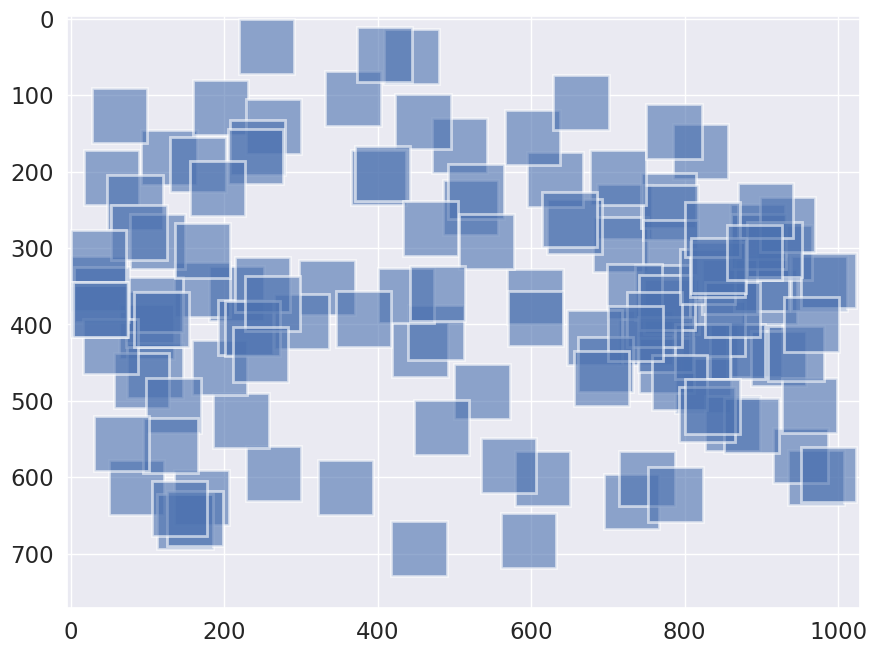

In [18]:
# todos los target boxes
target_boxes = dict()
for subj, value in subjs_response.items():
    for img, val in value.items():
        if img not in target_boxes.keys():
            target_boxes[img] = val['target_bbox'] #initial_fixation_row
target_boxes=pd.DataFrame(target_boxes).T
target_boxes.columns=['h1', 'w1', 'h2', 'w2']
target_boxes.head()

fig, ax1 = plt.subplots(1,1, figsize=(10.24,7.68))
for i, row in target_boxes.iterrows():
    ax1.add_patch(Rectangle((row.w1, row.h1), row.w2-row.w1, row.h2-row.h1, 
                           fill=True, linewidth=2, alpha=0.6))
ax1.set_xlim(-5,1024+5)
ax1.set_ylim(-3,768+3)
ax1.invert_yaxis()

134


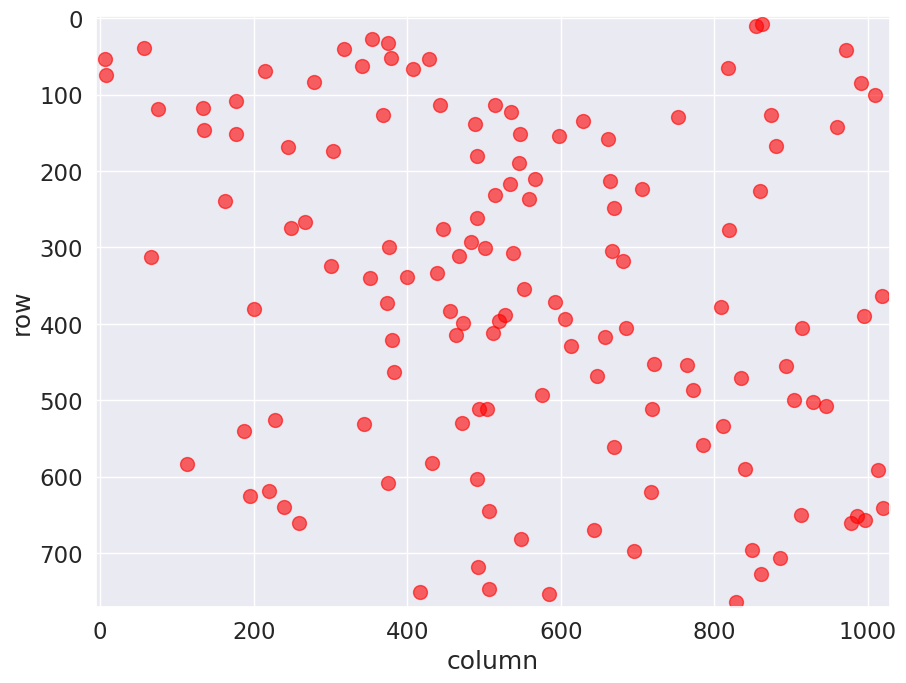

In [19]:
# todas las primeras fijaciones forzadas
first_forced_fix = dict()
for subj, value in subjs_response.items():
    for img, val in value.items():
        if img not in first_forced_fix.keys():
            first_forced_fix[img] = (val['initial_fixation_row'], val['initial_fixation_column'])  #initial_fixation_row
first_forced_fix=pd.DataFrame(first_forced_fix).T
first_forced_fix.columns=['row', 'column']
first_forced_fix.head()

fig, ax1 = plt.subplots(1,1, figsize=(10.24,7.68))
print(first_forced_fix.shape[0])
first_forced_fix.plot(x='column', y='row', ax=ax1, kind='scatter', c='red', s=100, alpha=0.6)
#f = first_forced_fix.plot.scatter(x='column', y='row', annontbackend='plotly')
#f.show()
ax1.set_xlim(-5,1024+5)
ax1.set_ylim(-3,768+3)
ax1.invert_yaxis()

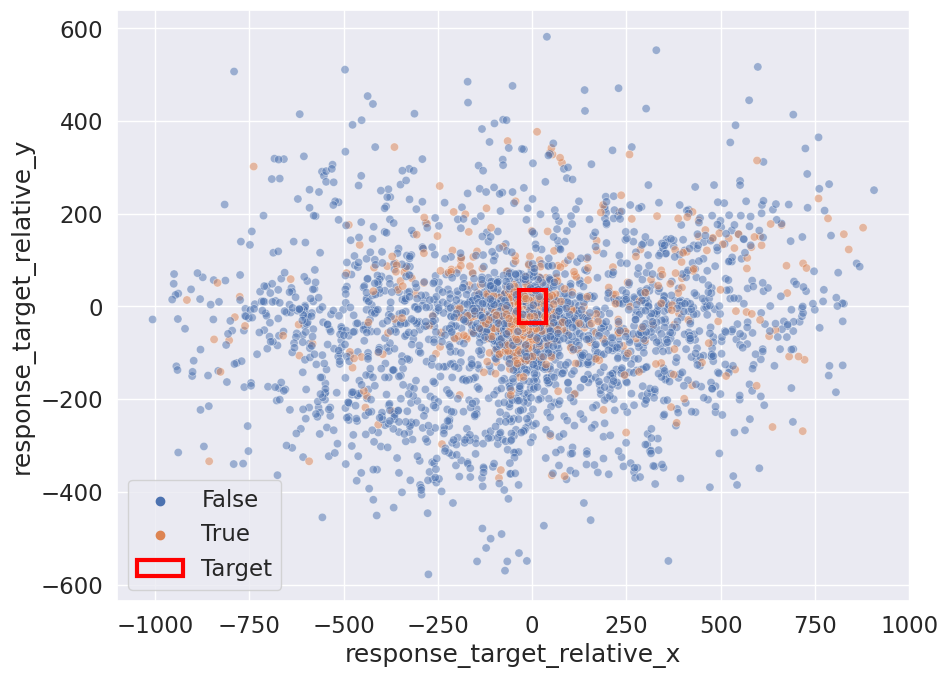

In [20]:
# Distribución de las respuestas objetivas
fig, ax = plt.subplots(1,1, figsize=(10.24, 7.68))
sns.scatterplot(x='response_target_relative_x', y='response_target_relative_y',hue='target_found',
                data=responses_data, alpha=0.5, ax=ax);
ax.add_patch(Rectangle((-36,-36), 72, 72, fill=False, edgecolor='red', linewidth=3, label='Target'))
ax.legend();

(0.0, 400.0)

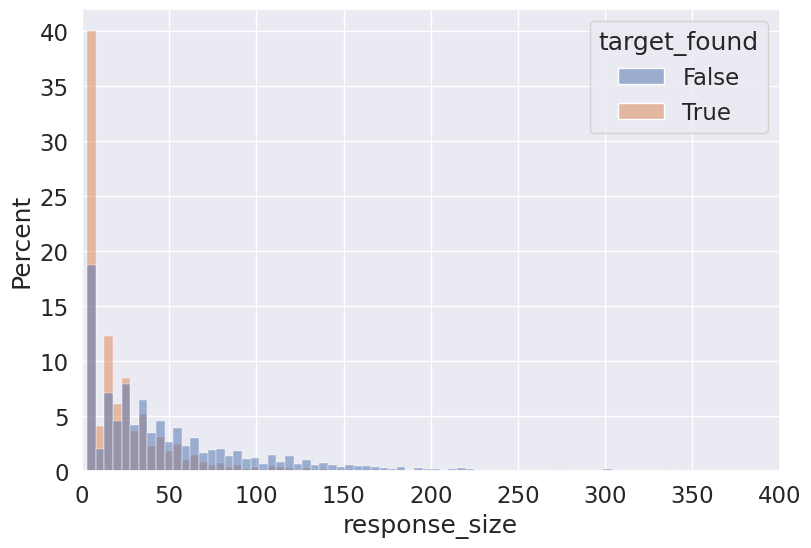

In [21]:
# Distribucion de las respuestas subjetivas
fig, ax = plt.subplots(1,1, figsize=(9,6))
sns.histplot(x='response_size', hue='target_found', data=responses_data, ax=ax, stat='percent', common_norm=False);
ax.set_xlim(0,400)

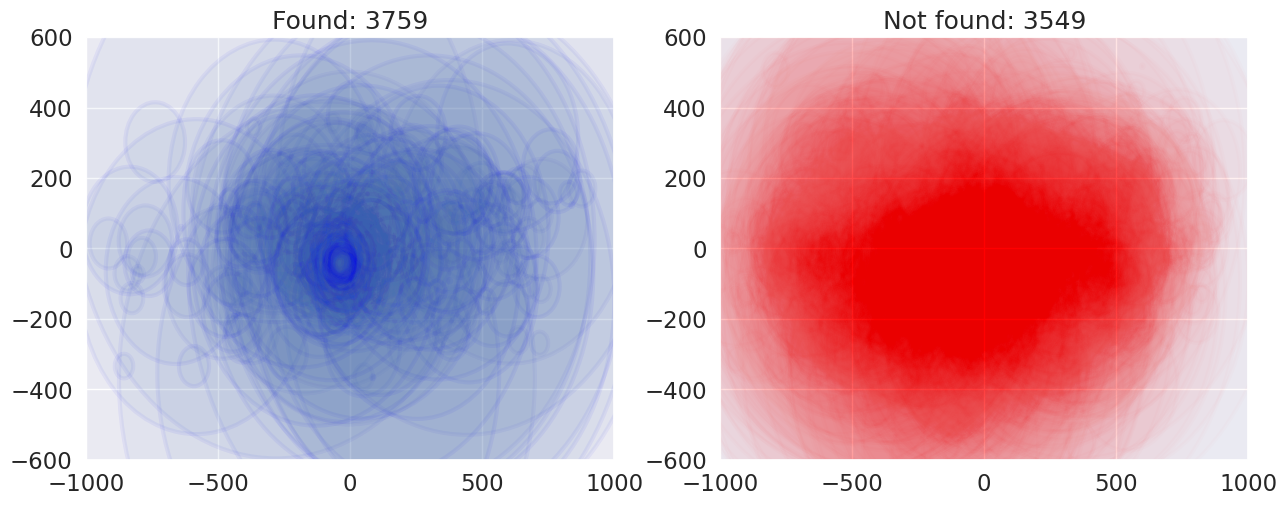

In [47]:
# all responses
if True:
    fig, ax = plt.subplots(1,2,figsize=(15,10))
    n_found , n_not_found = 0, 0
    for idx, row in responses_data.iterrows():
        rx = row.response_target_relative_x
        ry = row.response_target_relative_y
        r = row.response_size
        if row.target_found:
            ax[0].add_patch(Circle((rx,ry), r, fill=True, edgecolor='blue', linewidth=3, alpha=0.05))
            n_found += 1
        else:
            ax[1].add_patch(Circle((rx,ry), r, fill=True, facecolor='red', edgecolor='red', linewidth=3, alpha=0.01))
            n_not_found += 1
            
    ax[0].set_aspect(1024/768)
    ax[0].set_xlim(-1000, 1000)
    ax[0].set_ylim(-600, 600)
    ax[0].set_title(f'Found: {n_found}')
    ax[1].set_xlim(-1000, 1000)
    ax[1].set_ylim(-600, 600)
    ax[1].set_aspect(1024/768)
    ax[1].set_title(f'Not found: {n_not_found}')
    plt.show()

In [74]:
def add_target_patch(**kws):
    ax = plt.gca()
    ax.add_patch(Rectangle((-36,-36), 72, 72, fill=False, edgecolor='red', linewidth=3, label='Target'))

def add_amount_trials(**kws):
    ax = plt.gca()
    data = kws.pop('data')
    n = data.groupby(['target_found', 'max_fixations']).count().subj
    ax.text(f'{n}')

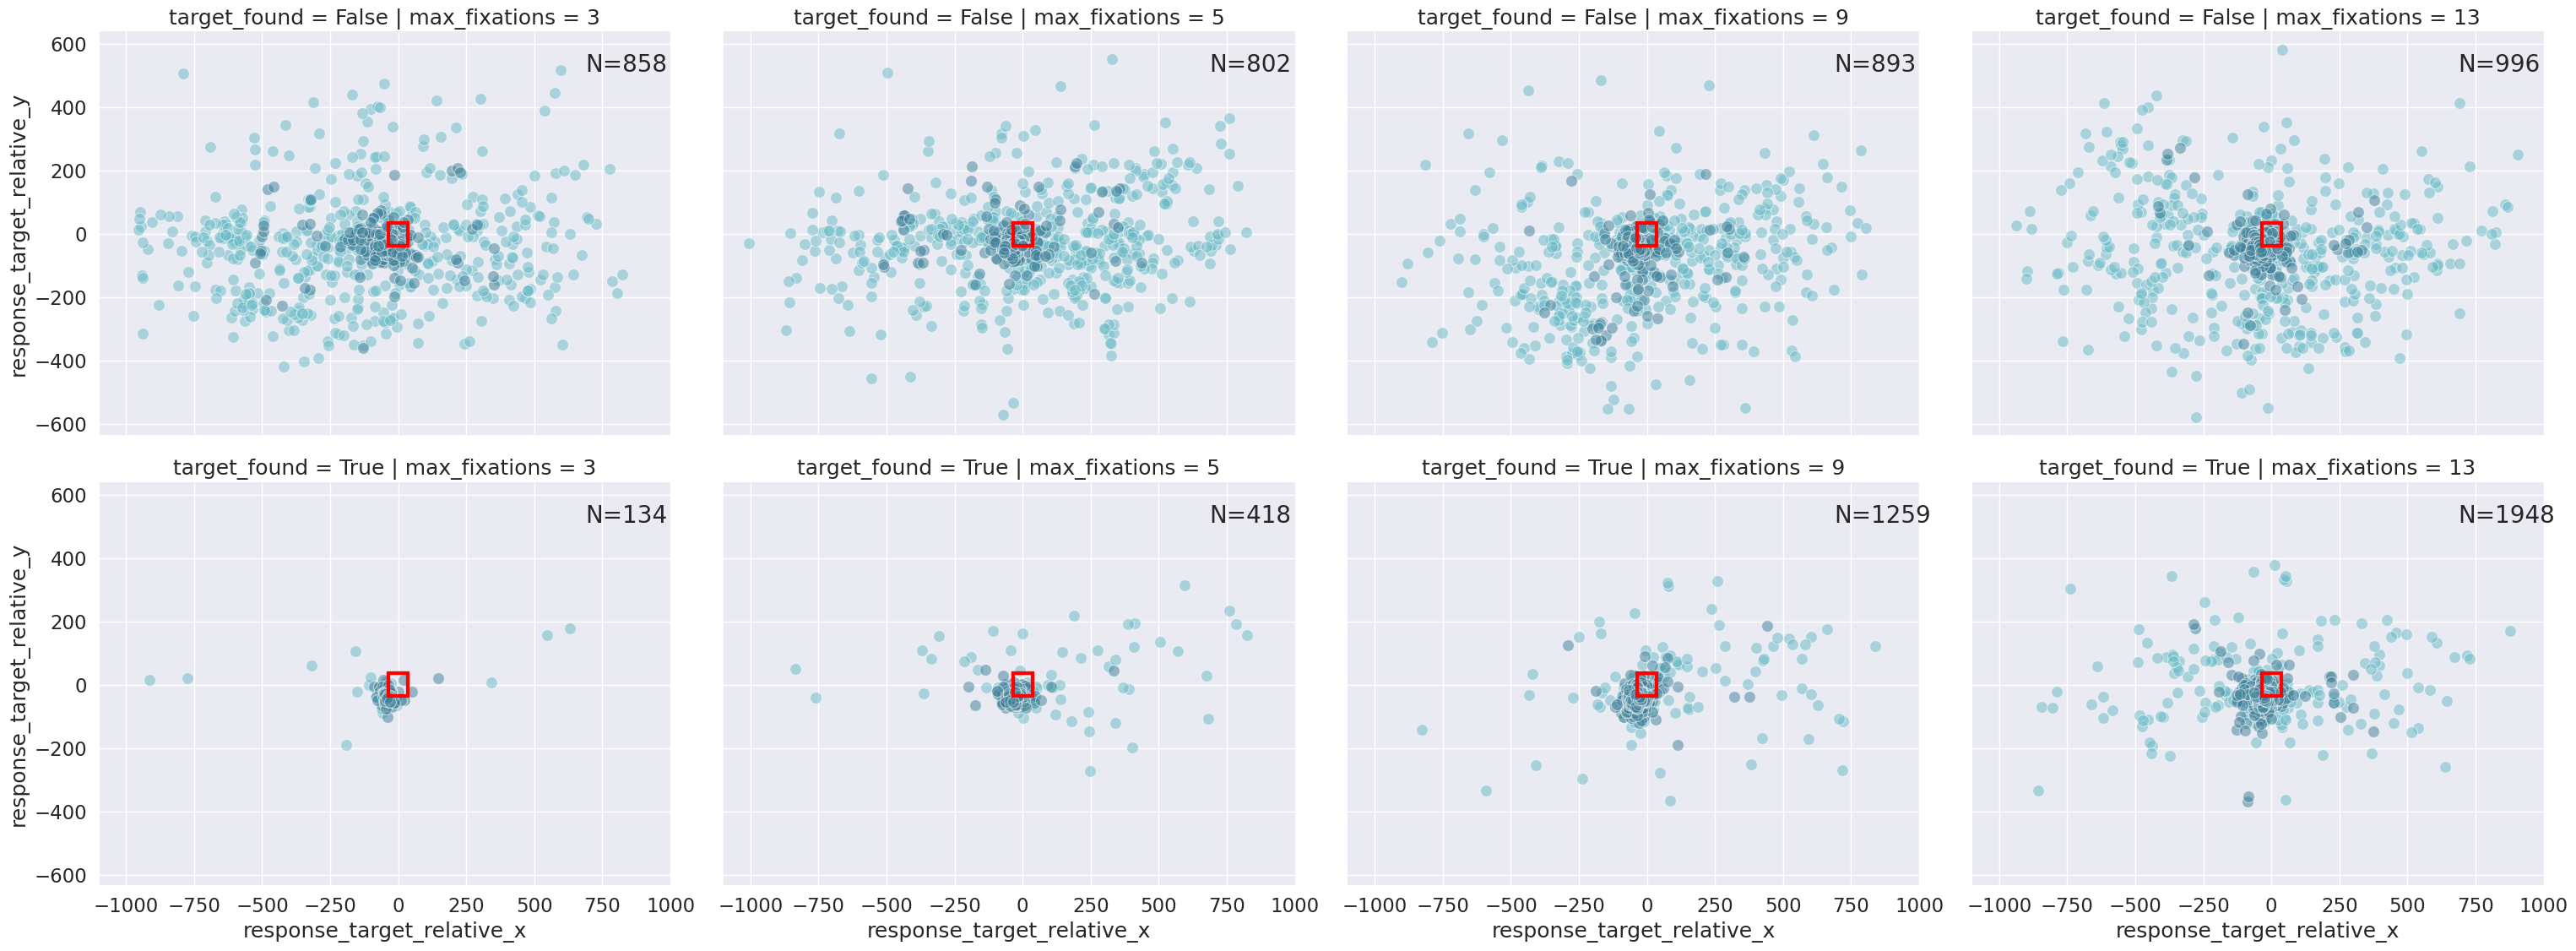

In [75]:
grid = sns.FacetGrid(responses_data, row="target_found",col="max_fixations", hue="target_found_response", 
                     palette="GnBu_d", height=5.8, aspect=1.33)

grid.map(sns.scatterplot, "response_target_relative_x", "response_target_relative_y", alpha=0.5, s=100);
grid.map_dataframe(add_target_patch)
ntrials = responses_data.groupby(['target_found', 'max_fixations']).count().subj
for ax, ((_,_), n) in zip(grid.axes.ravel(), ntrials.items()):
    ax.annotate(f'N={n}',xy=(0.85,0.9), xycoords ='axes fraction', fontsize=20)
grid.tight_layout()
plt.show()

## Distribución de fijaciones

In [143]:
# dataframe con los scanpaths
%autoreload
import mytools as tl
sdf = tl.create_scanpaths_df(subjs_response)
display(sdf.sample(5))
print(sdf.shape)

subj                             img fix_order      x      y    t  \
26990    15          grayscale_33_oliva.jpg         1  676.3  346.4  162   
22947     7     grayscale_11_opensource.jpg         1  604.4  306.1  164   
11545    23         grayscale_6_kitchen.jpg         2  798.3  496.7  437   
39250    50  grayscale_6_housebeautiful.jpg         9  279.8  582.1  257   
4395     22          grayscale_94_oliva.jpg         1  742.2  329.5  121   

       target_found  distance_to_target  
26990          True          570.207375  
22947         False          446.469898  
11545         False           65.533045  
39250         False          671.275986  
4395          False          180.737628

(50659, 8)


### Todas las fijaciones

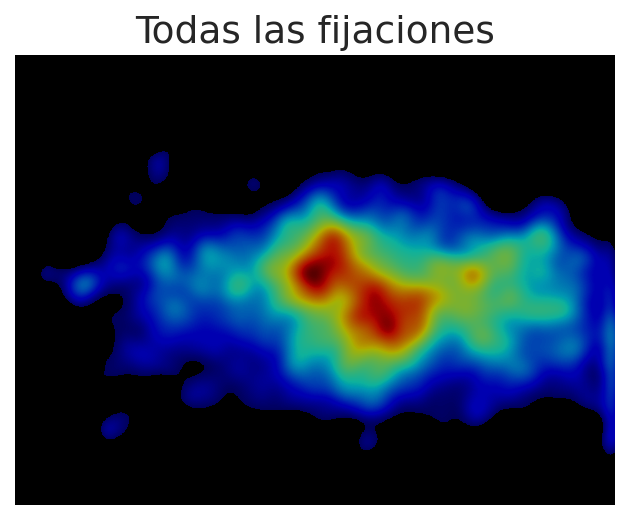

In [144]:
# heatmap de todas las fijaciones
_, hm = draw_heatmap(sdf.loc[:,['x', 'y']], alpha=0.7, title = 'Todas las fijaciones',savefigpath=figs_path)

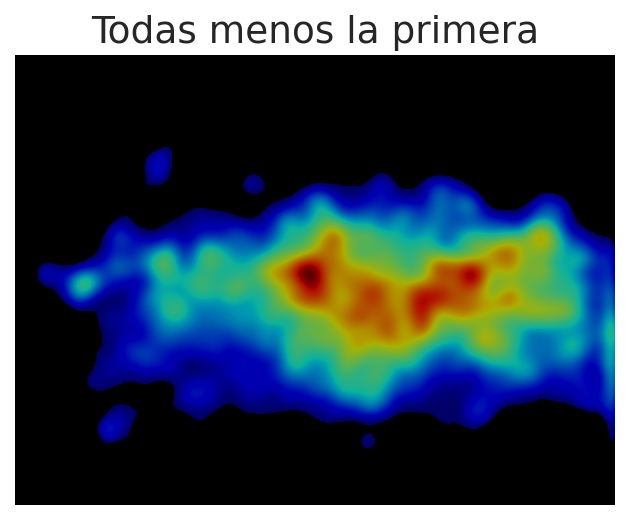

In [99]:
# heatmap de todas las fijaciones menos la primera
aux = sdf[sdf.fix_order!=0].loc[:,['x','y']]
_, hm = draw_heatmap(aux, alpha = 0.7, title = 'Todas menos la primera',savefigpath=figs_path)

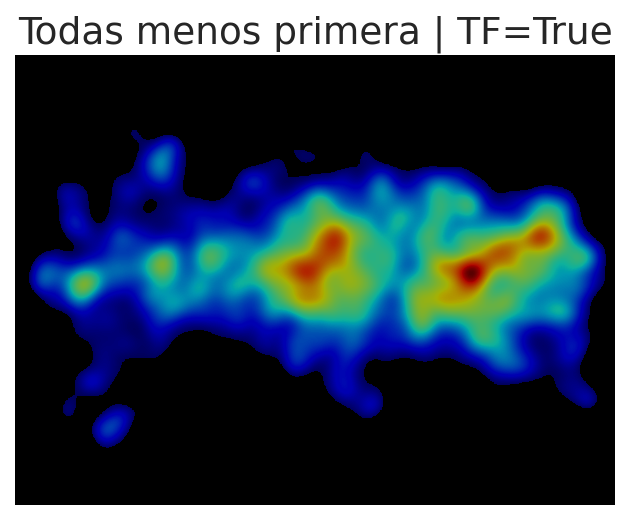

In [145]:
# heatmap de todos los target found menos la primera fijacion
aux = sdf[(sdf.target_found) & (sdf.fix_order!=0)].loc[:,['x','y']]
_, hm = draw_heatmap(aux, alpha=0.7, title='Todas menos primera | TF=True', savefigpath=None)

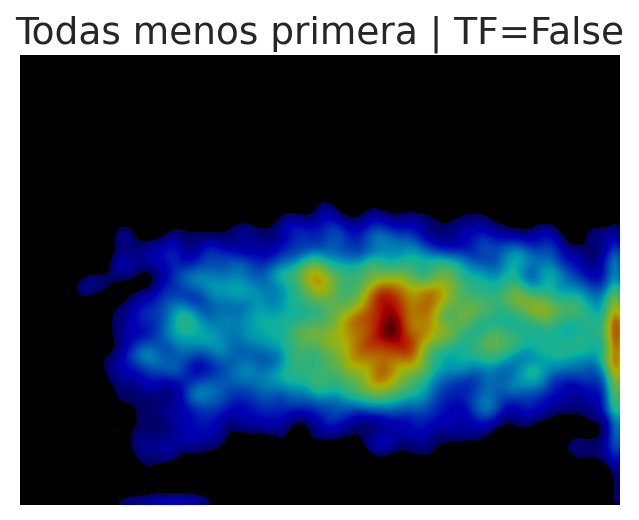

In [146]:
aux = sdf[~(sdf.target_found) & (sdf.fix_order!=0)].loc[:,['x','y']]
_, hm = draw_heatmap(aux, alpha=0.7, title='Todas menos primera | TF=False', savefigpath=figs_path)

### Todas las respuestas

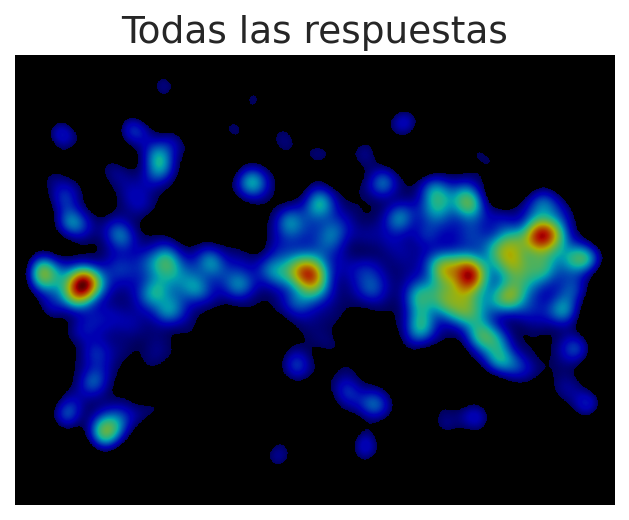

In [102]:
# distribución de las respuestas
sdf_r = tl.create_scanpaths_df(subjs_response)
aux = sdf_r[sdf_r.fix_order=='r'].loc[:,['x','y']]
_, hm = draw_heatmap(aux, alpha = 0.7, title = 'Todas las respuestas', savefigpath=figs_path)

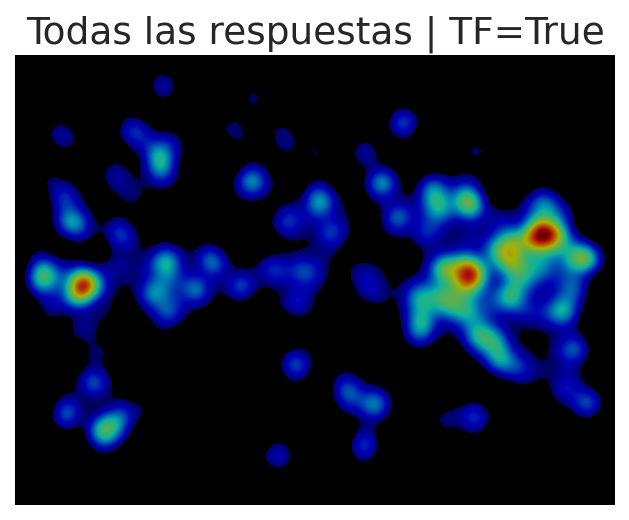

In [103]:
# todas las respuestas target found
aux = sdf_r[(sdf_r.fix_order=='r') & (sdf_r.target_found)].loc[:,['x','y']]
_, hm = draw_heatmap(aux, alpha = 0.7, title = 'Todas las respuestas | TF=True',savefigpath=figs_path)

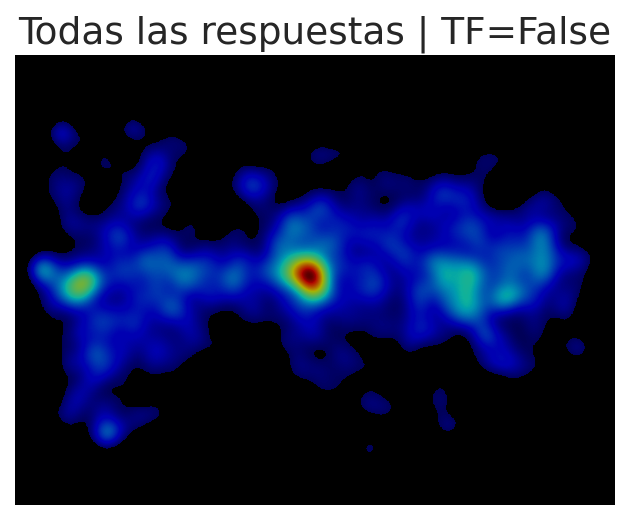

In [104]:
# todas las respuestas target not found
aux = sdf_r[(sdf_r.fix_order=='r') & ~(sdf_r.target_found)].loc[:,['x','y']]
_, hm = draw_heatmap(aux, alpha = 0.7, title = 'Todas las respuestas | TF=False',savefigpath=figs_path)

### Gráficos de trials individuales

In [133]:
# Elegimos una imagen
#image_name = 'grayscale_100_oliva.jpg' 
#image_name='grayscale_11_opensource.jpg'
image_name='grayscale_30_opensource.jpg'
# subjs[subj][image_name]['target_bbox'][:2]
# _ = tl.plot_fixposmap(subjs_response_found, image_file=image_name, 
        #    image_path = os.path.join(data_path,'images'), plot_save_path=None)
print(data_path)
print(resp_path)

../Datasets/Interiors
../Datasets/Interiors/responses


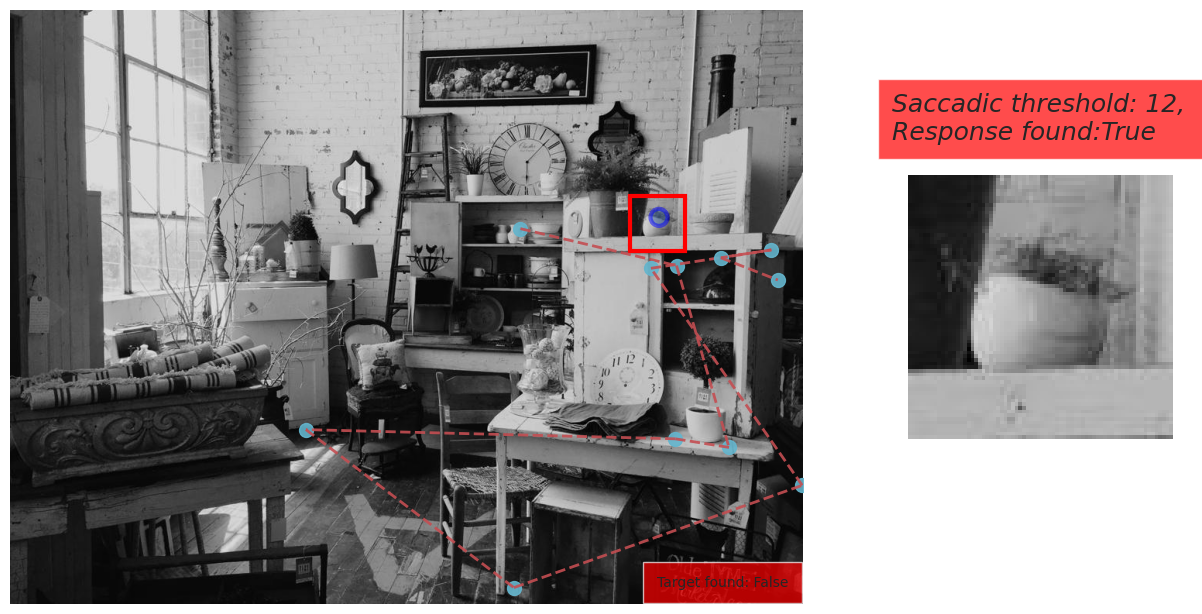

In [129]:
%autoreload
import mytools as tl
tl.plot_trial_subject_response(subj=15, 
                                image_name=image_name,
                                data_path=data_path,
                                resp_path=resp_path,
                                y_correction = False,
                                show_scanpath=True)

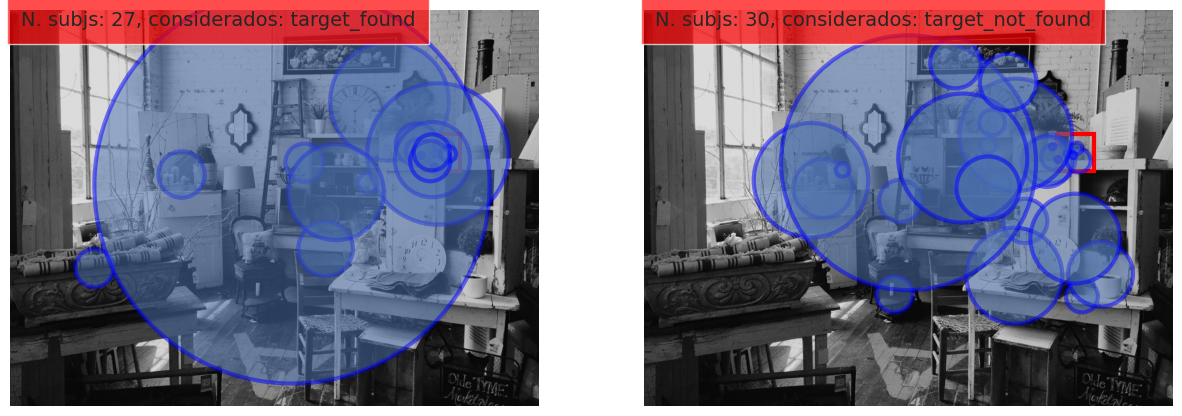

In [141]:
_,ax = plt.subplots(1,2,figsize=(15,7))

tl.plot_image_responses(image_name=image_name,
                        data_path=data_path,
                        resp_path=resp_path,
                        y_correction = False,
                        use='target_found',
                        ax=ax[0])

tl.plot_image_responses(image_name=image_name,
                        data_path=data_path,
                        resp_path=resp_path,
                        y_correction = False,
                        use='target_not_found',
                        ax=ax[1])


## Análisis de las respuestas

En esta parte la idea seria analizar como fueron las respuestas, como se agruparon, que relación tienen con los dos tipos de respuesta entre si, con la distancia al target, con el logaritmo de la distancia al target, con el hecho de haber encontrado el target.

In [ ]:
#sns.set_context(context='notebook', font_scale=1.1)
# Histogramas exploratorios
#responses_data.loc[:,responses_data.columns.difference(['subj'])].hist(figsize=(16,12), bins=15);

### Respuesta objetiva

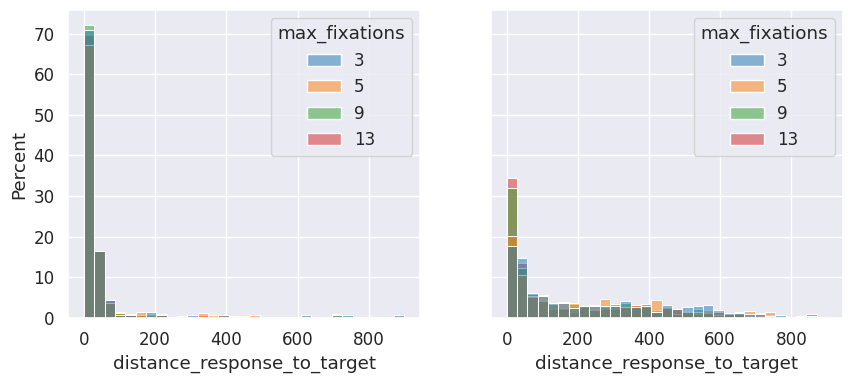

In [172]:
# Agrupemos por max fixations y veamos que pasa con las respuestas segun la cantidad de sacadas permitidas

palette = sns.color_palette('tab10',4)
_, ax = plt.subplots(1,2, figsize=(10,4), sharey=True)
bins_pixels = np.linspace(0, 900, 32)
sns.histplot(x='distance_response_to_target',hue= 'max_fixations',data=responses_data[responses_data.target_found],
                bins = bins_pixels, palette=palette, ax=ax[0], stat='percent', common_norm=False);
sns.histplot(x='distance_response_to_target',hue= 'max_fixations',data=responses_data[~responses_data.target_found],
                bins = bins_pixels, palette=palette, ax=ax[1], stat='percent', common_norm=False);


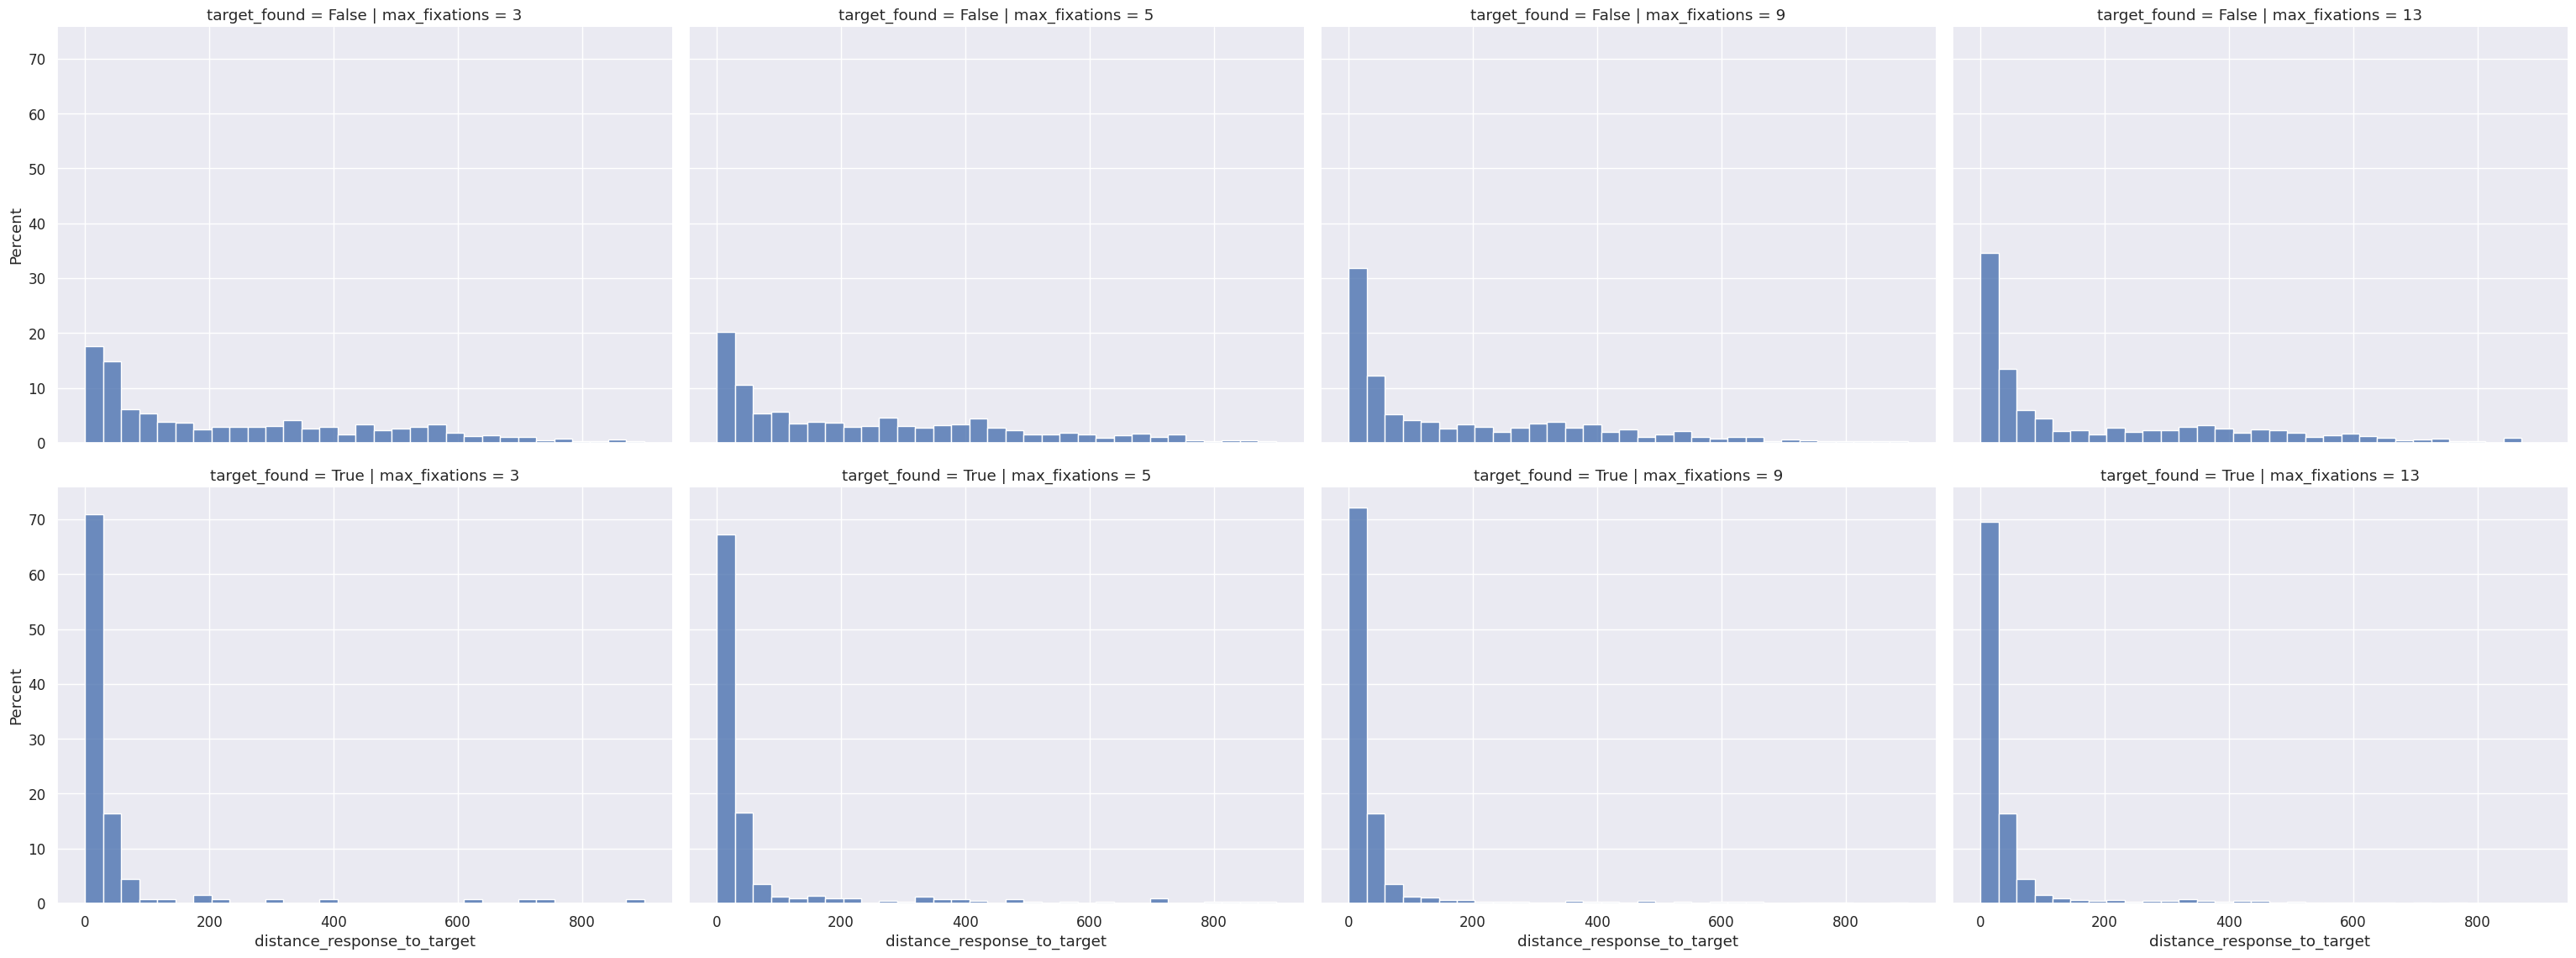

In [168]:
# separar estos histogramas por max_fixations
# col="max_fixations", hue="target_found_response",
var="distance_response_to_target"
grid = sns.FacetGrid(responses_data, col="max_fixations", row='target_found',
                    palette="GnBu_d", height=5.8, aspect=1.33)

grid.map(sns.histplot, var, stat='percent', alpha=0.8, common_norm=False, bins=bins_pixels);
grid.tight_layout()
plt.show()
# plt.savefig(os.path.join(figs_path, f'grid_{var}.png'))

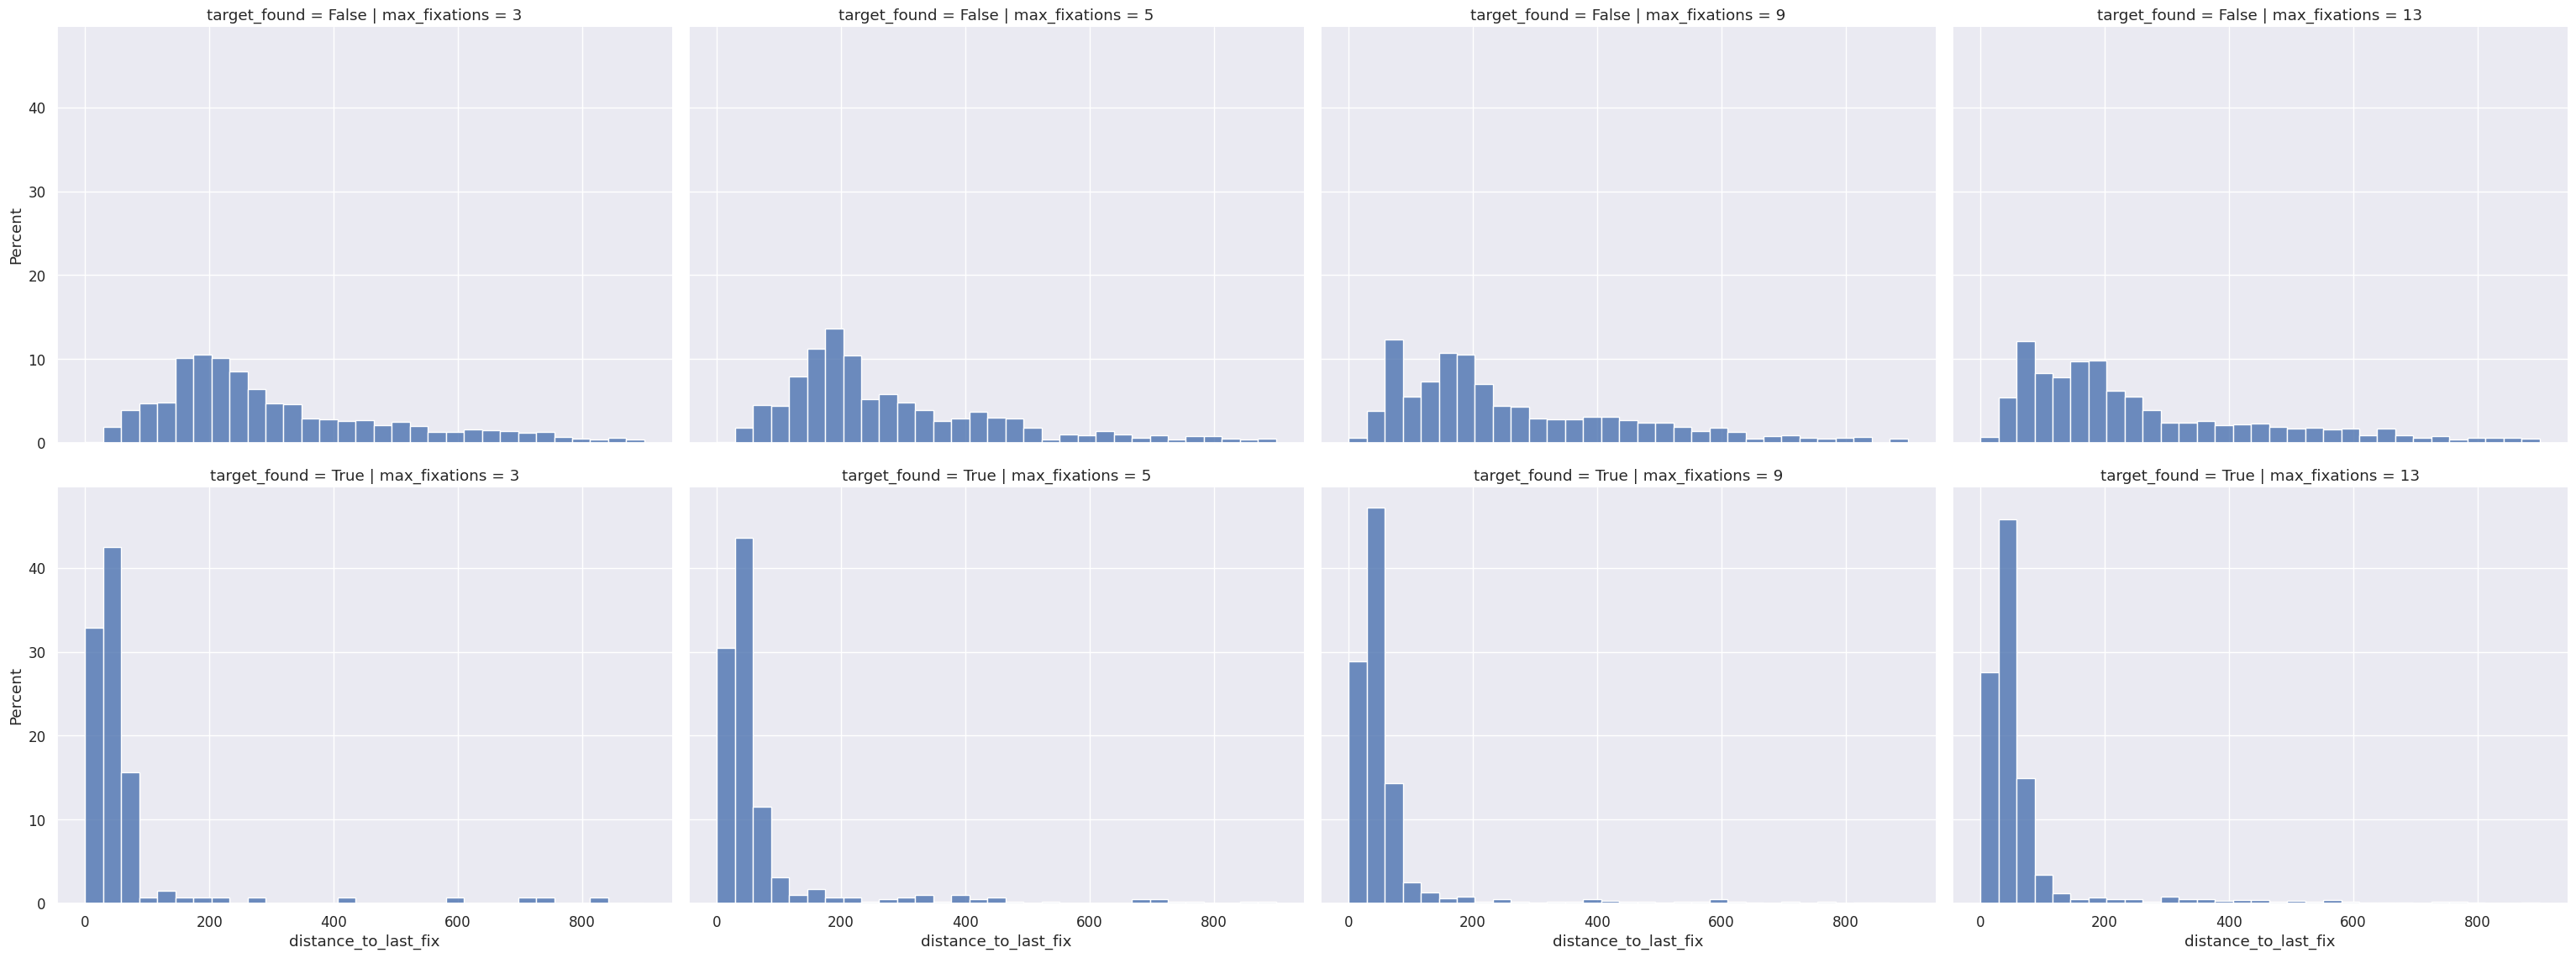

In [169]:
var = "distance_to_last_fix"
grid = sns.FacetGrid(responses_data, col="max_fixations", row="target_found",
                    palette="GnBu_d", height=5.8, aspect=1.33)
bins_hist = np.linspace(0,1000, 20)
grid.map(sns.histplot, var, stat='percent', alpha=0.8, common_norm=False, bins=bins_pixels);
grid.tight_layout()
plt.show()
# plt.savefig(os.path.join(figs_path, f'grid_{var}.png'))

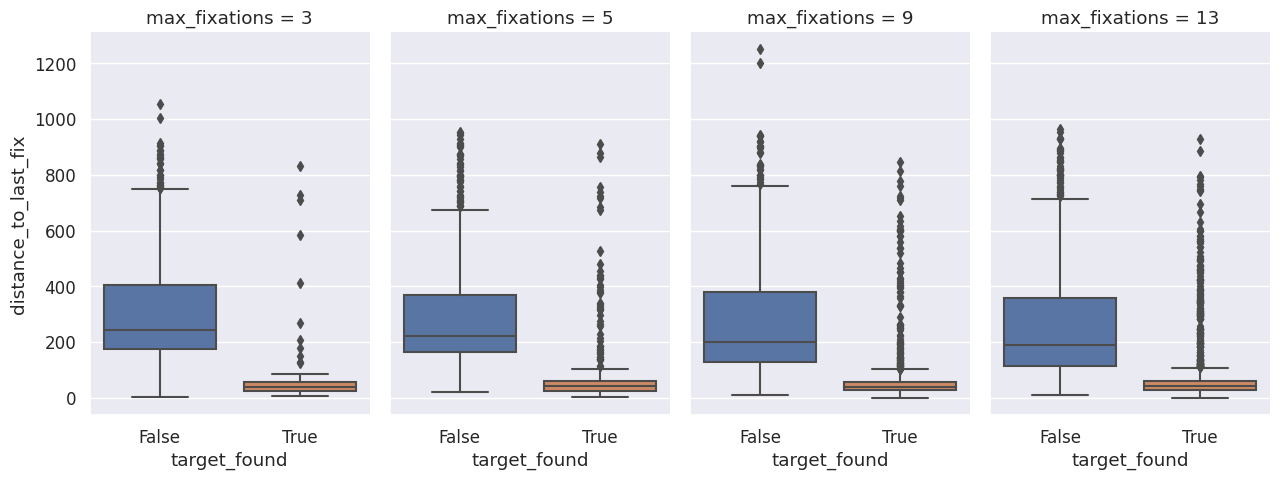

In [160]:
g = sns.catplot(
    data=responses_data, x="target_found", y=var, col="max_fixations",
    kind="box", height=5, aspect=.65,
)
# g.savefig(os.path.join(figs_path, f'grid_{var}_boxplot.png'))

### Respuesta subjetiva

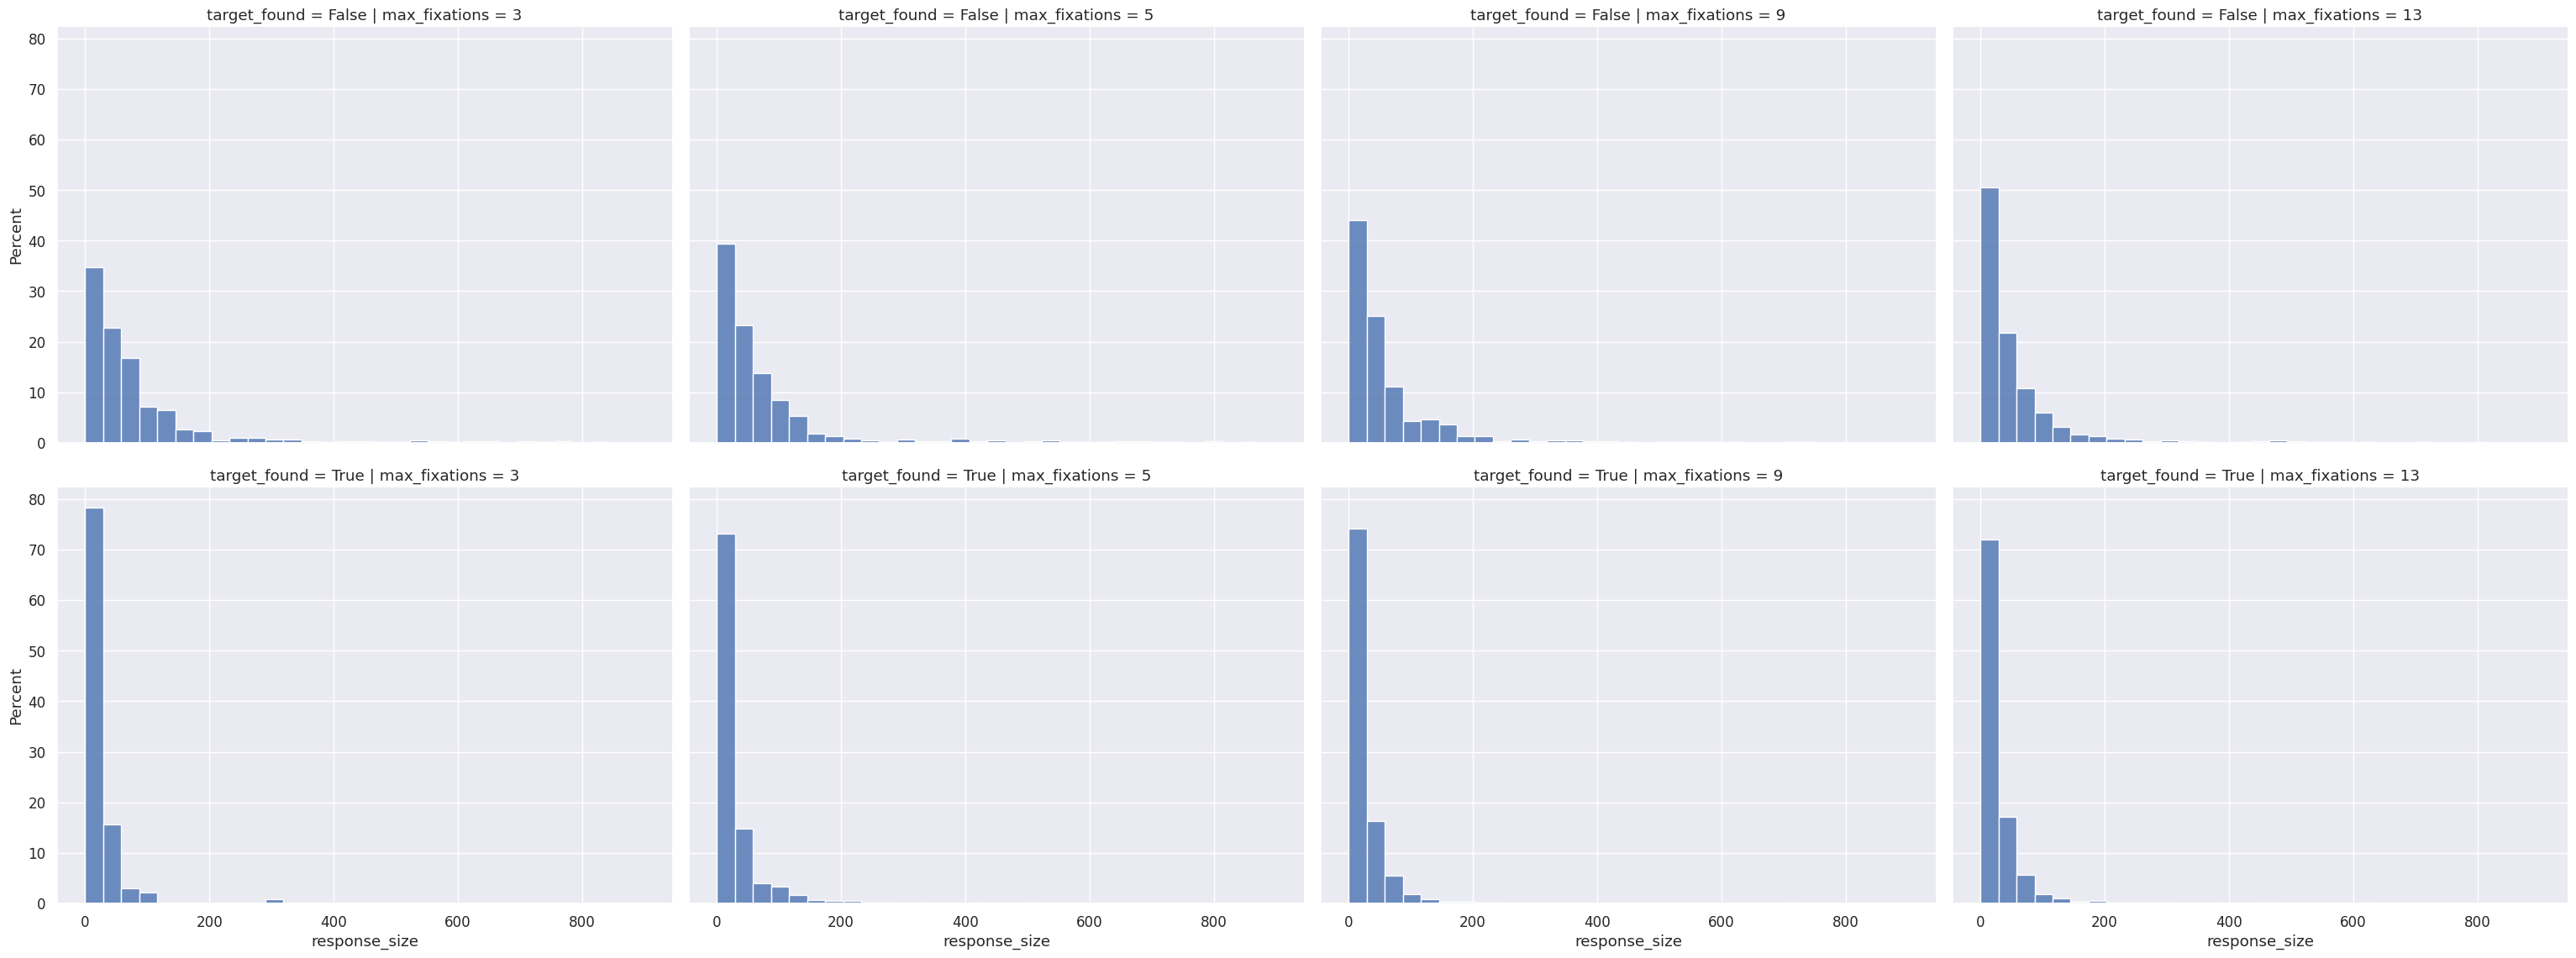

In [170]:
var = "response_size"
grid = sns.FacetGrid(responses_data, col="max_fixations", row='target_found',
                    palette="GnBu_d", height=5.8, aspect=1.33)
bins_hist = np.linspace(0,600, 25)
grid.map(sns.histplot, var, stat='percent', alpha=0.8, common_norm=False, bins=bins_pixels);

grid.tight_layout()
plt.show()
# plt.savefig(os.path.join(figs_path, f'grid_{var}.png'))

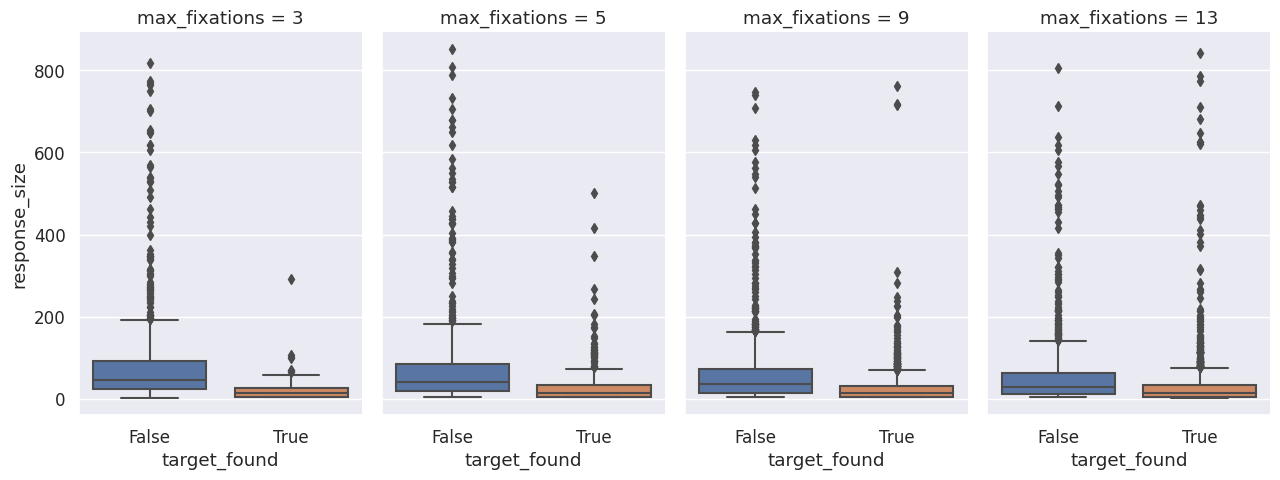

In [171]:
g = sns.catplot(
    data=responses_data, x="target_found", y=var, col="max_fixations",
    kind="box", height=5, aspect=.65,
)
# g.savefig(os.path.join(figs_path, f'grid_{var}_boxplot.png'))

### Tiempo entre respuestas

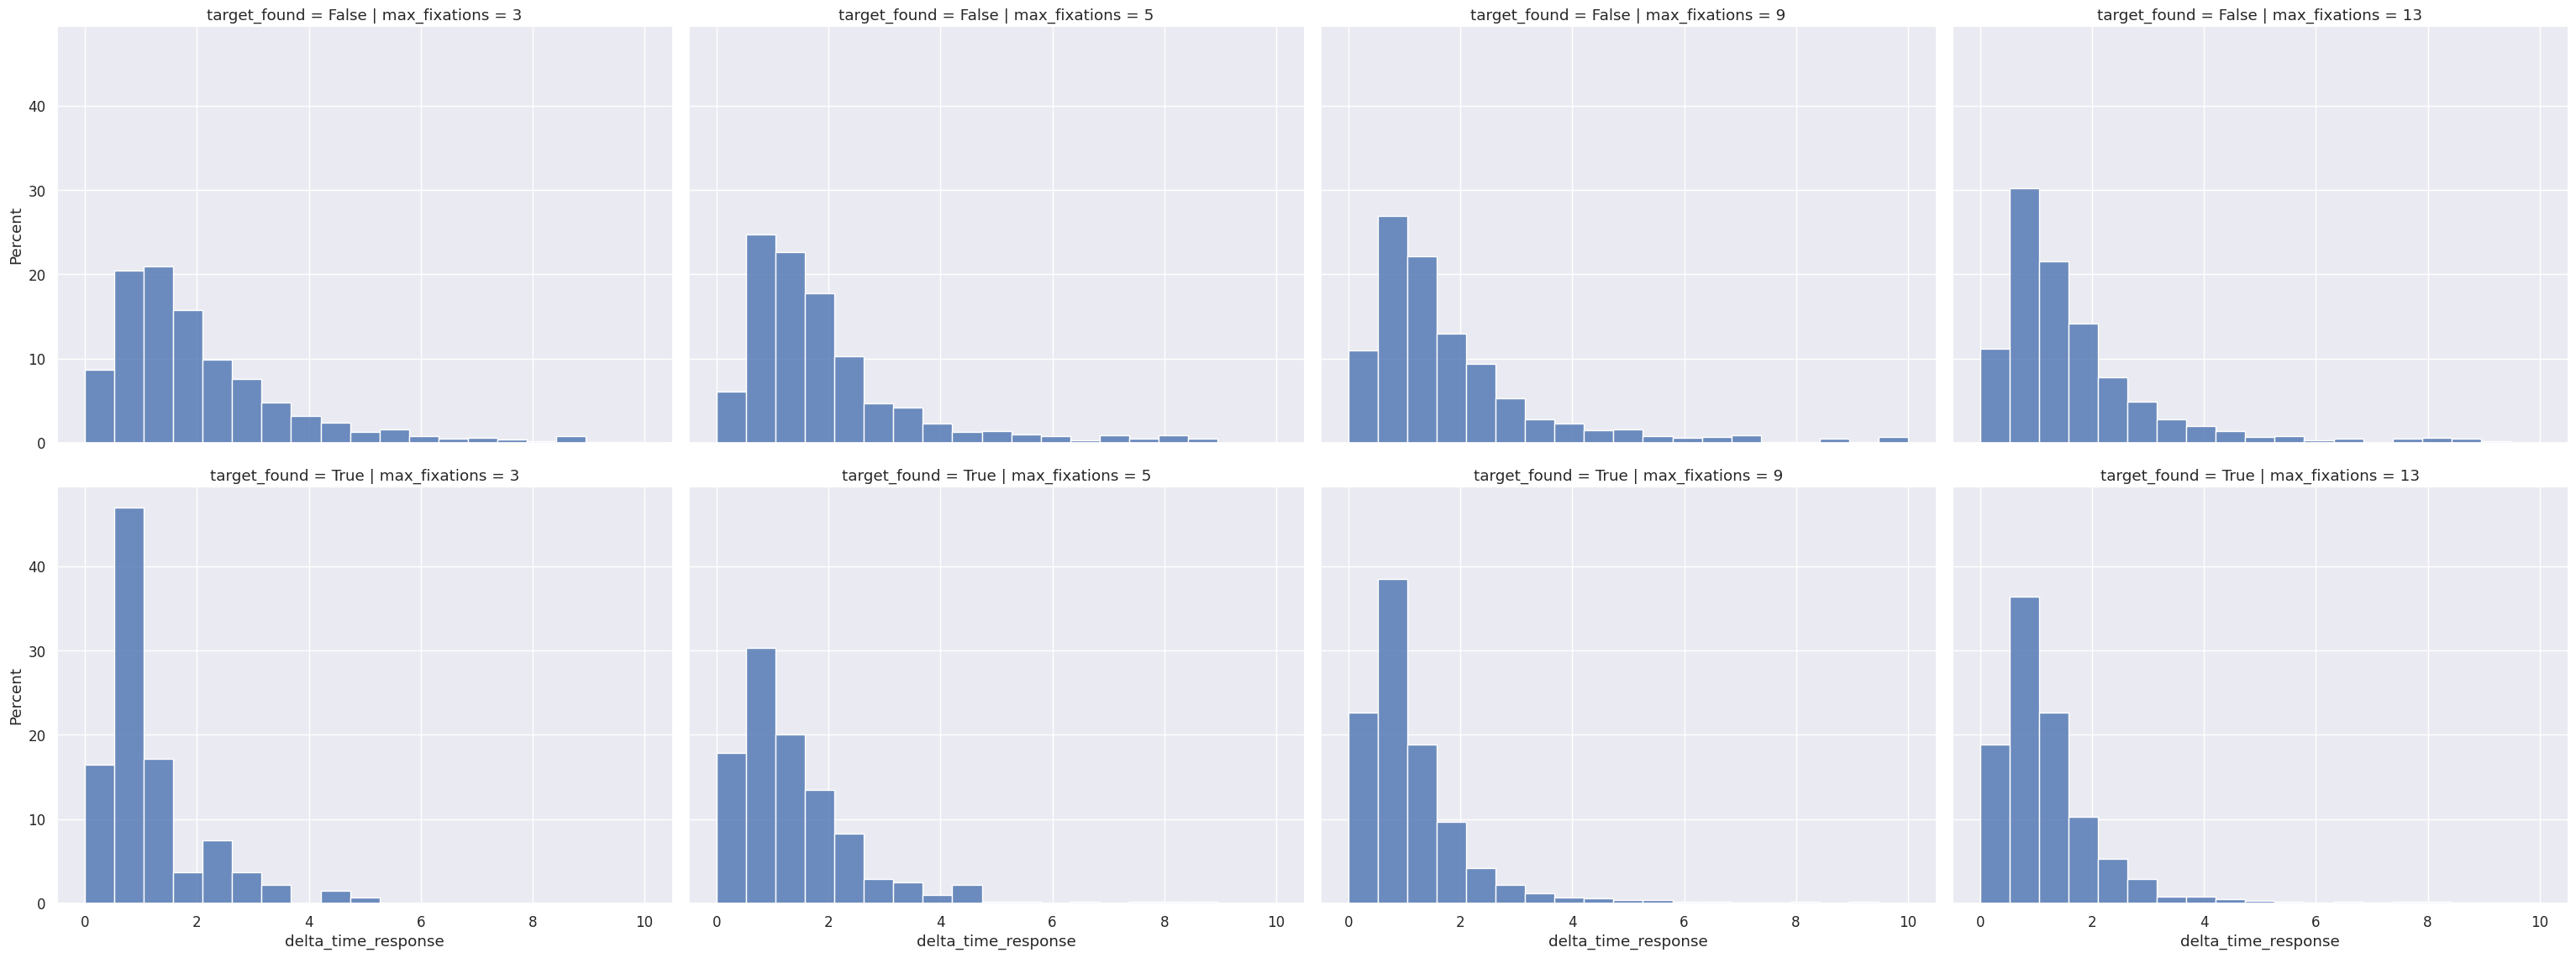

In [173]:
var = "delta_time_response"
grid = sns.FacetGrid(responses_data, col="max_fixations", row='target_found',
                    palette="GnBu_d", height=5.8, aspect=1.33)
bins_hist = np.linspace(0,10, 20)
grid.map(sns.histplot, var, stat='percent', alpha=0.8, common_norm=False, bins=bins_hist);
grid.tight_layout()
plt.show()
# plt.savefig(os.path.join(figs_path, f'grid_{var}.png'))

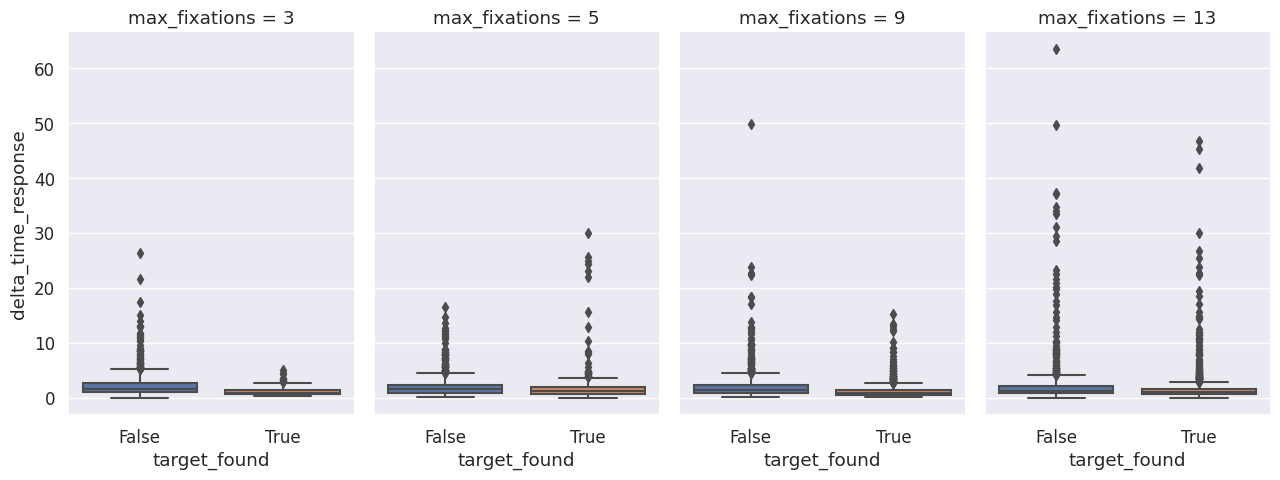

In [175]:
g = sns.catplot(
    data=responses_data, x="target_found", y=var, col="max_fixations",
    kind="box", height=5, aspect=.65,
)
# g.savefig(os.path.join(figs_path, f'grid_{var}_boxplot.png'))

### Algunos gráficos adicionales

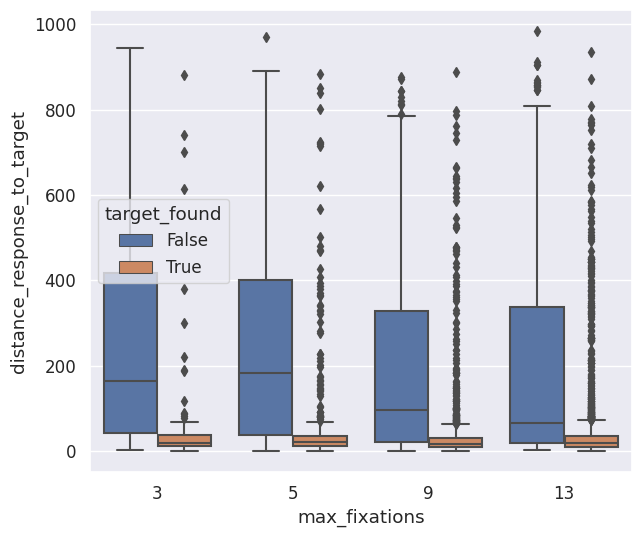

In [177]:
_,ax=plt.subplots(1,1, sharey=True, figsize=(7,6))

sns.boxplot(x='max_fixations',
            y='distance_response_to_target',
            hue='target_found',
            data=responses_data,
            ax=ax
            )

# sns.boxplot(x='max_fixations',
#             y='distance_response_to_target',
#             hue='target_found_response',
#             data=responses_data,
#             ax=ax[1]
#             )

plt.show()

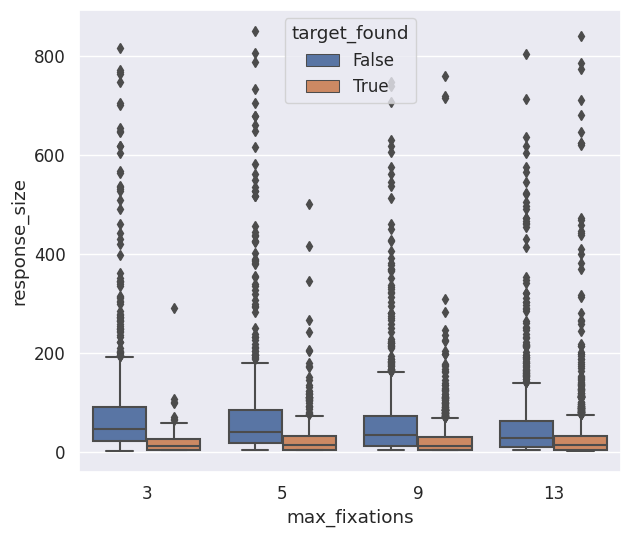

In [178]:
_,ax=plt.subplots(1,1, sharey=True, figsize=(7,6))

sns.boxplot(x='max_fixations',
            y='response_size',
            hue='target_found',
            data=responses_data,
            ax=ax
            )

# sns.boxplot(x='max_fixations',
#             y='response_size',
#             hue='target_found_response',
#             data=responses_data,
#             ax=ax[1]
#             )

plt.show()

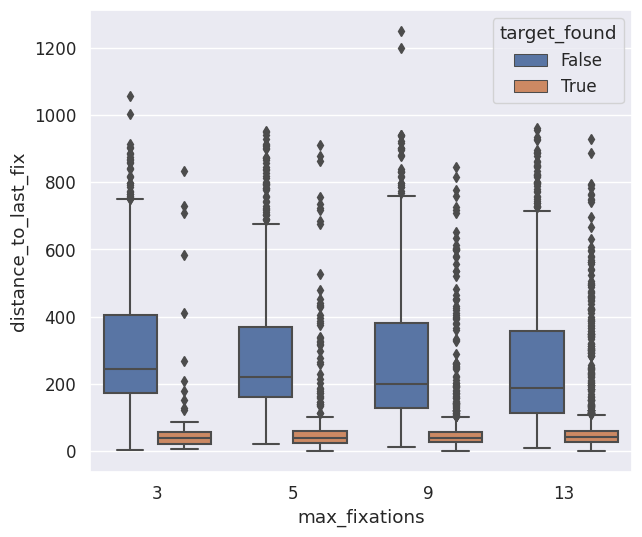

In [179]:
_,ax=plt.subplots(1,1, sharey=True, figsize=(7,6))

sns.boxplot(x='max_fixations',
            y='distance_to_last_fix',
            hue='target_found',
            data=responses_data,
            ax=ax
            )

# sns.boxplot(x='max_fixations',
#             y='distance_to_last_fix',
#             hue='target_found_response',
#             data=responses_data,
#             ax=ax[1]
#             )

plt.show()

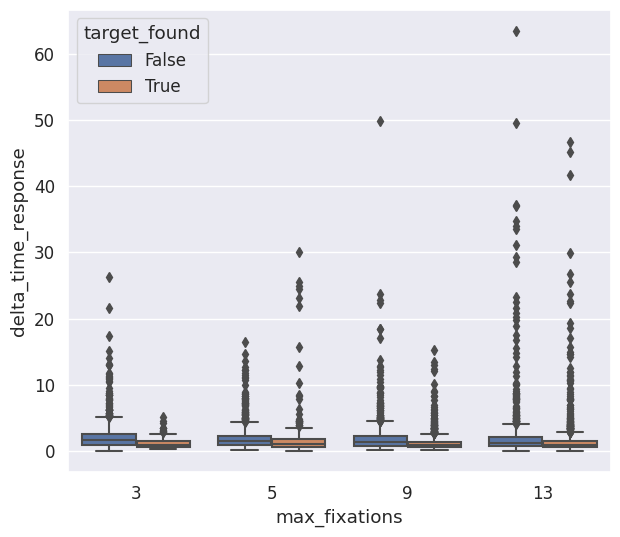

In [180]:
_,ax=plt.subplots(1,1, sharey=True, figsize=(7,6))

sns.boxplot(x='max_fixations',
            y='delta_time_response',
            hue='target_found',
            data=responses_data,
            ax=ax
            )

plt.show()

## Análisis de respuestas (log)

In [86]:
responses_data['delta_time_response_log']  = np.log(responses_data['delta_time_response'])
responses_data['distance_response_to_target_log']   = np.log(responses_data['distance_response_to_target'])
responses_data['distance_to_last_fix_log'] = np.log(responses_data['distance_to_last_fix'])
responses_data['response_size_log']        = np.log(responses_data['response_size'])
responses_data.head()

/home/gastonb/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


subj                              img  max_fixations  scanpath_length  \
0    41      grayscale_11_opensource.jpg             13               10   
1    41  grayscale_18_housebeautiful.jpg              9               10   
2    41          grayscale_100_oliva.jpg              5                3   
3    41           grayscale_17_oliva.jpg              3                2   
4    41  grayscale_16_housebeautiful.jpg              3                4   

   target_found  target_found_response  response_size  \
0         False                  False             29   
1         False                  False             47   
2          True                  False             19   
3         False                  False             35   
4         False                  False             19   

   distance_response_to_target  distance_to_last_fix  delta_time_response  \
0                   266.810794            213.164661            49.599536   
1                   329.200547            411.615026             9.666707   
2                   202.054448            204.544005             5.633140   
3                   297.692795            208.923431             4.266648   
4                   568.198029            223.650531             2.900187   

   response_x  response_y  target_bbox_x  target_bbox_y  \
0       486.0       447.0            228            559   
1       520.0       538.0            797            400   
2       714.0       218.0            713            381   
3       433.0       316.0            186            490   
4       762.0       442.0            158            421   

   response_target_relative_x  response_target_relative_y  \
0                      -258.0                       112.0   
1                       277.0                      -138.0   
2                        -1.0                       163.0   
3                      -247.0                       174.0   
4                      -604.0                       -21.0   

   delta_time_response_log  distance_response_to_target_log  \
0                 3.903981                         5.586540   
1                 2.268688                         5.796667   
2                 1.728667                         5.308537   
3                 1.450829                         5.696062   
4                 1.064775                         6.342470   

   distance_to_last_fix_log  response_size_log  
0                  5.362065           3.367296  
1                  6.020089           3.850148  
2                  5.320783           2.944439  
3                  5.341968           3.555348  
4                  5.410085           2.944439

In [87]:
# cheqeuo de infs
print(responses_data['distance_response_to_target_log'].min())
mymask = [responses_data['distance_response_to_target_log'] == -np.inf]
print('Cantidad de menos infinito: {}'.format(responses_data[responses_data['distance_response_to_target_log'] == -np.inf].shape[0]))
(responses_data==-np.inf).sum()

-inf
Cantidad de menos infinito: 4


subj                               0
img                                0
max_fixations                      0
scanpath_length                    0
target_found                       0
target_found_response              0
response_size                      0
distance_response_to_target        0
distance_to_last_fix               0
delta_time_response                0
response_x                         0
response_y                         0
target_bbox_x                      0
target_bbox_y                      0
response_target_relative_x         0
response_target_relative_y         0
delta_time_response_log            0
distance_response_to_target_log    4
distance_to_last_fix_log           0
response_size_log                  0
dtype: int64

In [88]:
# reemplazo esos valores
responses_data.replace(-np.inf, 0, inplace=True)
(responses_data==-np.inf).sum()

subj                               0
img                                0
max_fixations                      0
scanpath_length                    0
target_found                       0
target_found_response              0
response_size                      0
distance_response_to_target        0
distance_to_last_fix               0
delta_time_response                0
response_x                         0
response_y                         0
target_bbox_x                      0
target_bbox_y                      0
response_target_relative_x         0
response_target_relative_y         0
delta_time_response_log            0
distance_response_to_target_log    0
distance_to_last_fix_log           0
response_size_log                  0
dtype: int64

In [89]:
# el tamaño minimo de la respuesta parece ser de 3 pixeles
aux_min_response = np.exp(responses_data['response_size_log'].min())
print(f'Minimo tamaño de respuesta: {aux_min_response:0.02f}')

Minimo tamaño de respuesta: 3.00


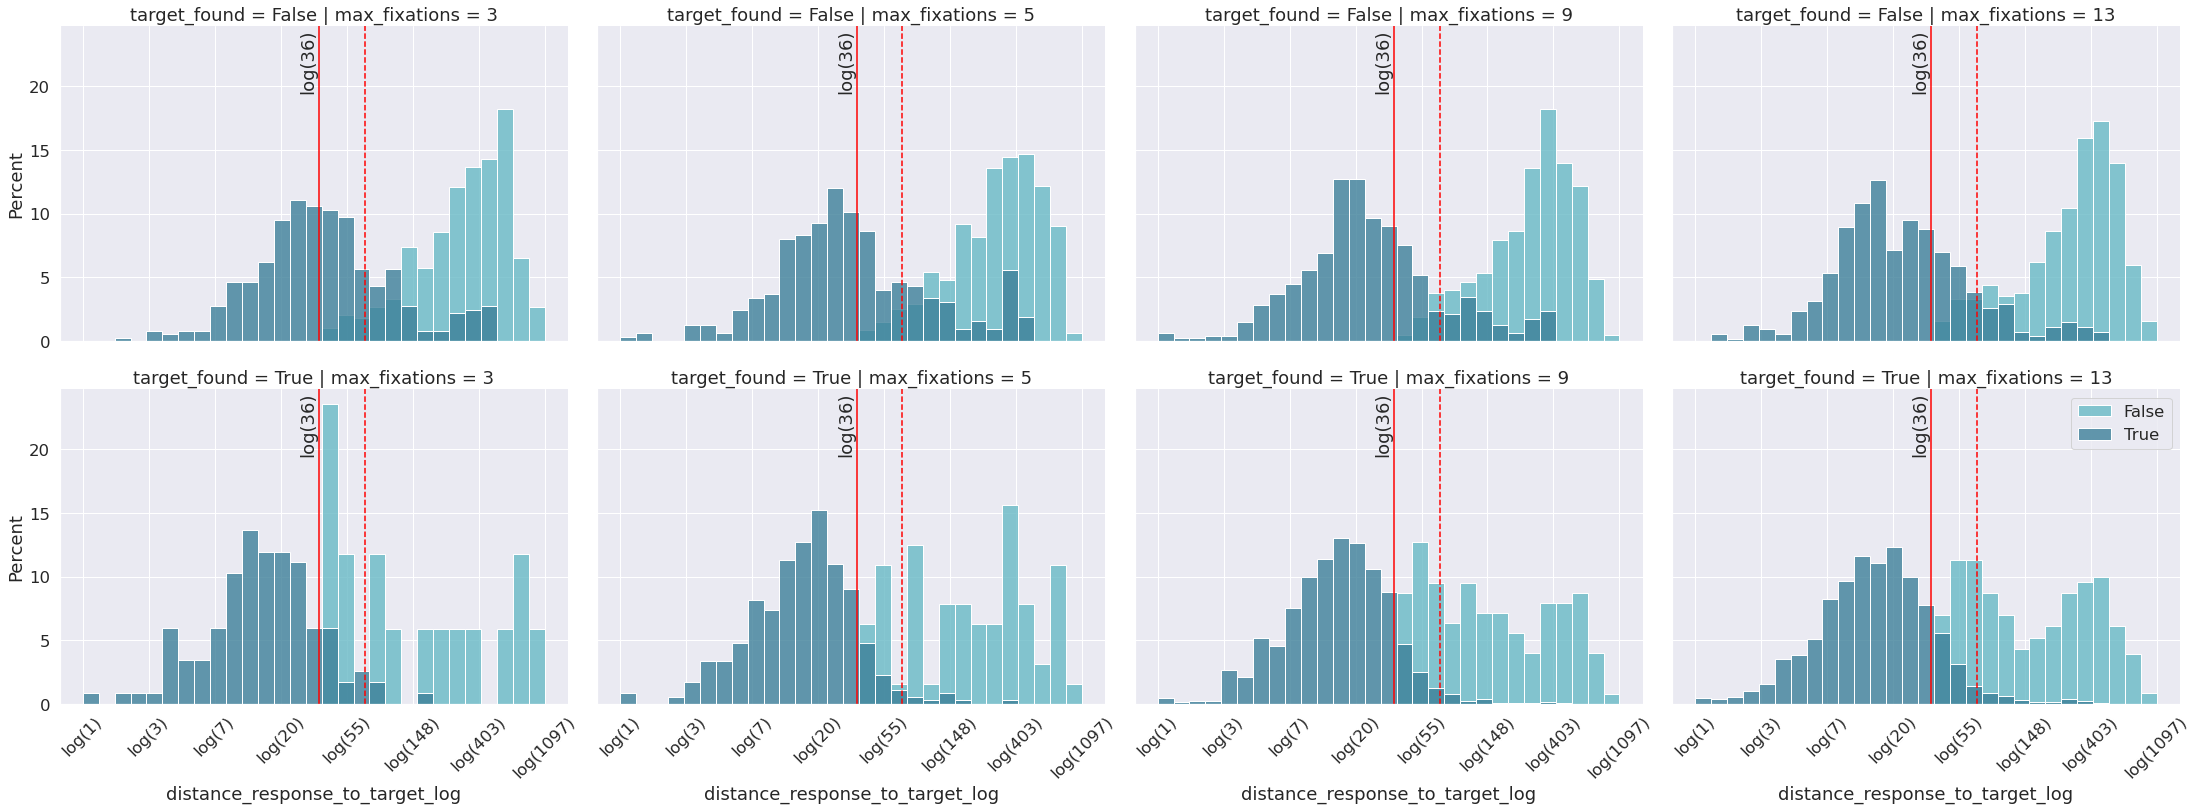

In [91]:
# distance_response_to_target_log
var = "distance_response_to_target_log"
grid = sns.FacetGrid(responses_data, col="max_fixations", row='target_found', hue='target_found_response',
                    palette="GnBu_d", height=5.8, aspect=1.33)

bins_hist = np.linspace(0,7,30)
grid.map(sns.histplot, var,bins=bins_hist, stat='percent', alpha=0.8, common_norm=False);
for i, ax in enumerate(grid.axes.ravel()):
    ax.axvline(np.log(36),color='red')
    ax.axvline(np.log(72),color='red',ls='--')
    trans = ax.get_xaxis_transform()
    ax.text(np.log(36)-0.3, .8, 'log(36)', transform=trans, rotation=90)
    if i > 3:
        ax.set_xticks(range(8))
        ax.set_xticklabels([f'log({np.exp(x):.0f})' for x in range(8)], rotation=45)
            
grid.tight_layout()
plt.legend()
plt.savefig(os.path.join(figs_path, f'grid_{var}.png'))

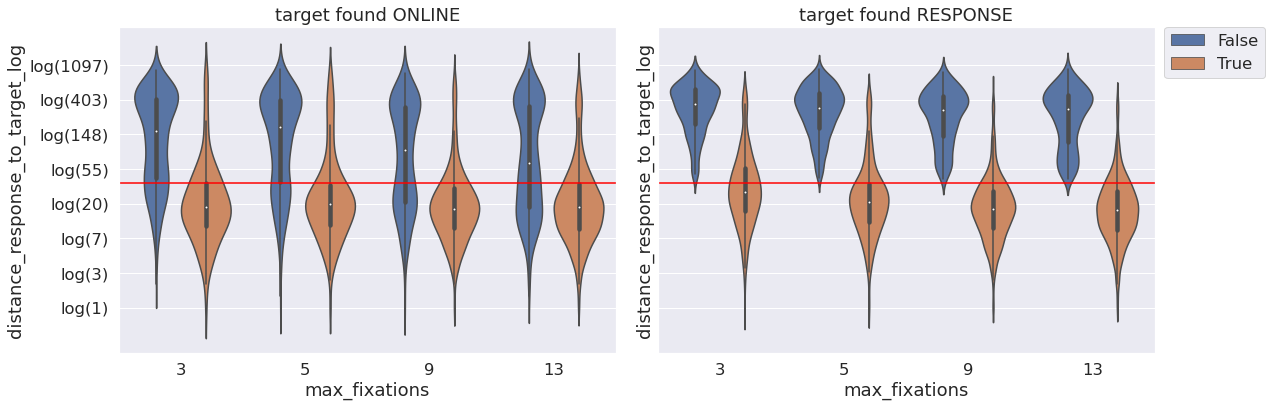

In [92]:
_,ax=plt.subplots(1,2, sharey=True, figsize=(18,6))

#g = sns.boxplot(x='max_fixations',
g = sns.violinplot(x='max_fixations',
            y=var,
            hue='target_found',
            data=responses_data,
            ax=ax[0])    

ax[0].legend([], frameon=False)
ax[0].set_title('target found ONLINE')
ax[0].set_yticks(range(8))
ax[0].set_yticklabels([f'log({np.exp(x):.0f})' for x in range(8)])
sns.violinplot(x='max_fixations',
            y=var,
            hue='target_found_response',
            data=responses_data,
            ax=ax[1])
ax[1].set_title('target found RESPONSE')
ax[0].axhline(np.log(36),color='red')
ax[1].axhline(np.log(36),color='red')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.savefig(os.path.join(figs_path, f'grid_{var}_violinplot.png'))

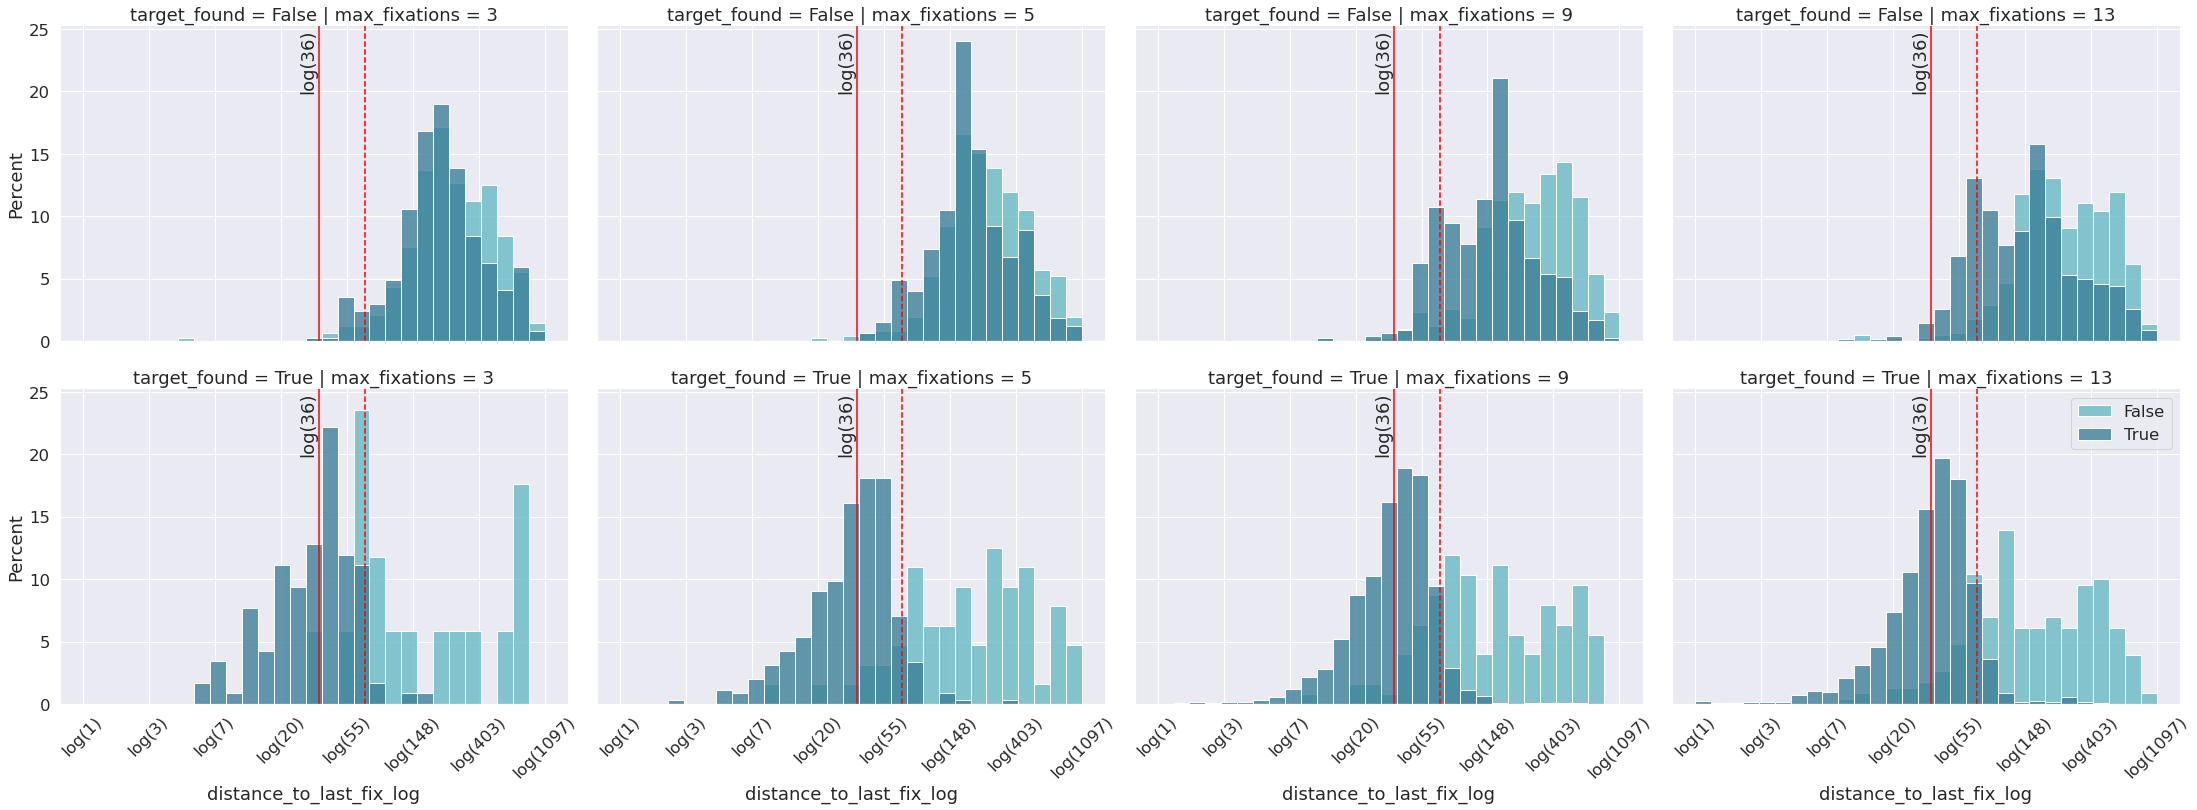

In [93]:
# distance_to_last_fix_log
var = "distance_to_last_fix_log"
grid = sns.FacetGrid(responses_data, col="max_fixations", row='target_found', hue='target_found_response',
                    palette="GnBu_d", height=5.8, aspect=1.33)

bins_hist = np.linspace(0,7,30)
grid.map(sns.histplot, var,bins=bins_hist, stat='percent', alpha=0.8, common_norm=False);
for i, ax in enumerate(grid.axes.ravel()):
    ax.axvline(np.log(36),color='red')
    ax.axvline(np.log(72),color='red',ls='--')
    trans = ax.get_xaxis_transform()
    ax.text(np.log(36)-0.3, .8, 'log(36)', transform=trans, rotation=90)
    if i > 3:
        ax.set_xticks(range(8))
        ax.set_xticklabels([f'log({np.exp(x):.0f})' for x in range(8)], rotation=45)
    
grid.tight_layout()
plt.legend()
plt.savefig(os.path.join(figs_path, f'grid_{var}.png'))

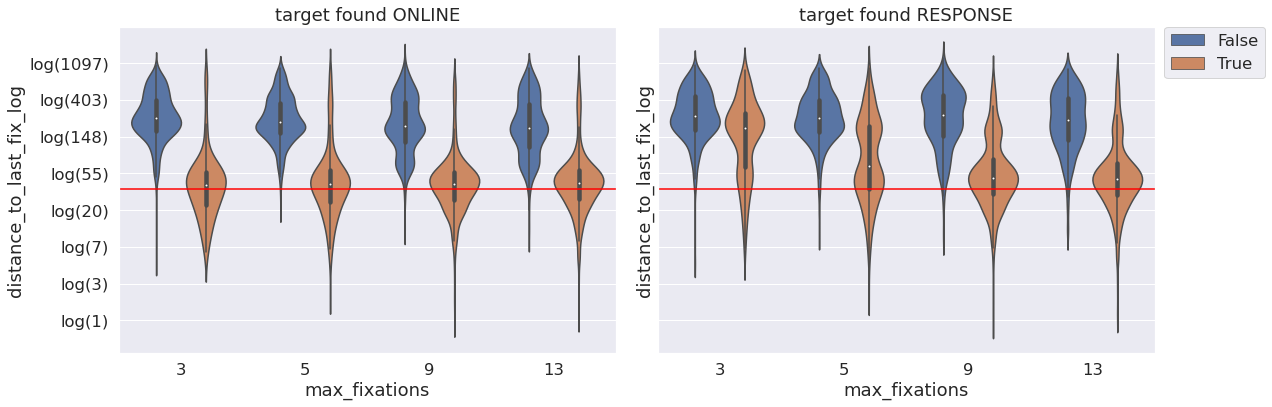

In [94]:
_,ax=plt.subplots(1,2, sharey=True, figsize=(18,6))

g = sns.violinplot(x='max_fixations',
            y=var,
            hue='target_found',
            data=responses_data,
            ax=ax[0])

ax[0].legend([], frameon=False)
ax[0].set_title('target found ONLINE')
ax[0].set_yticks(range(8))
ax[0].set_yticklabels([f'log({np.exp(x):.0f})' for x in range(8)])
sns.violinplot(x='max_fixations',
            y=var,
            hue='target_found_response',
            data=responses_data,
            ax=ax[1])
ax[1].set_title('target found RESPONSE')
ax[0].axhline(np.log(36),color='red')
ax[1].axhline(np.log(36),color='red')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.savefig(os.path.join(figs_path, f'grid_{var}_violinplot.png'))

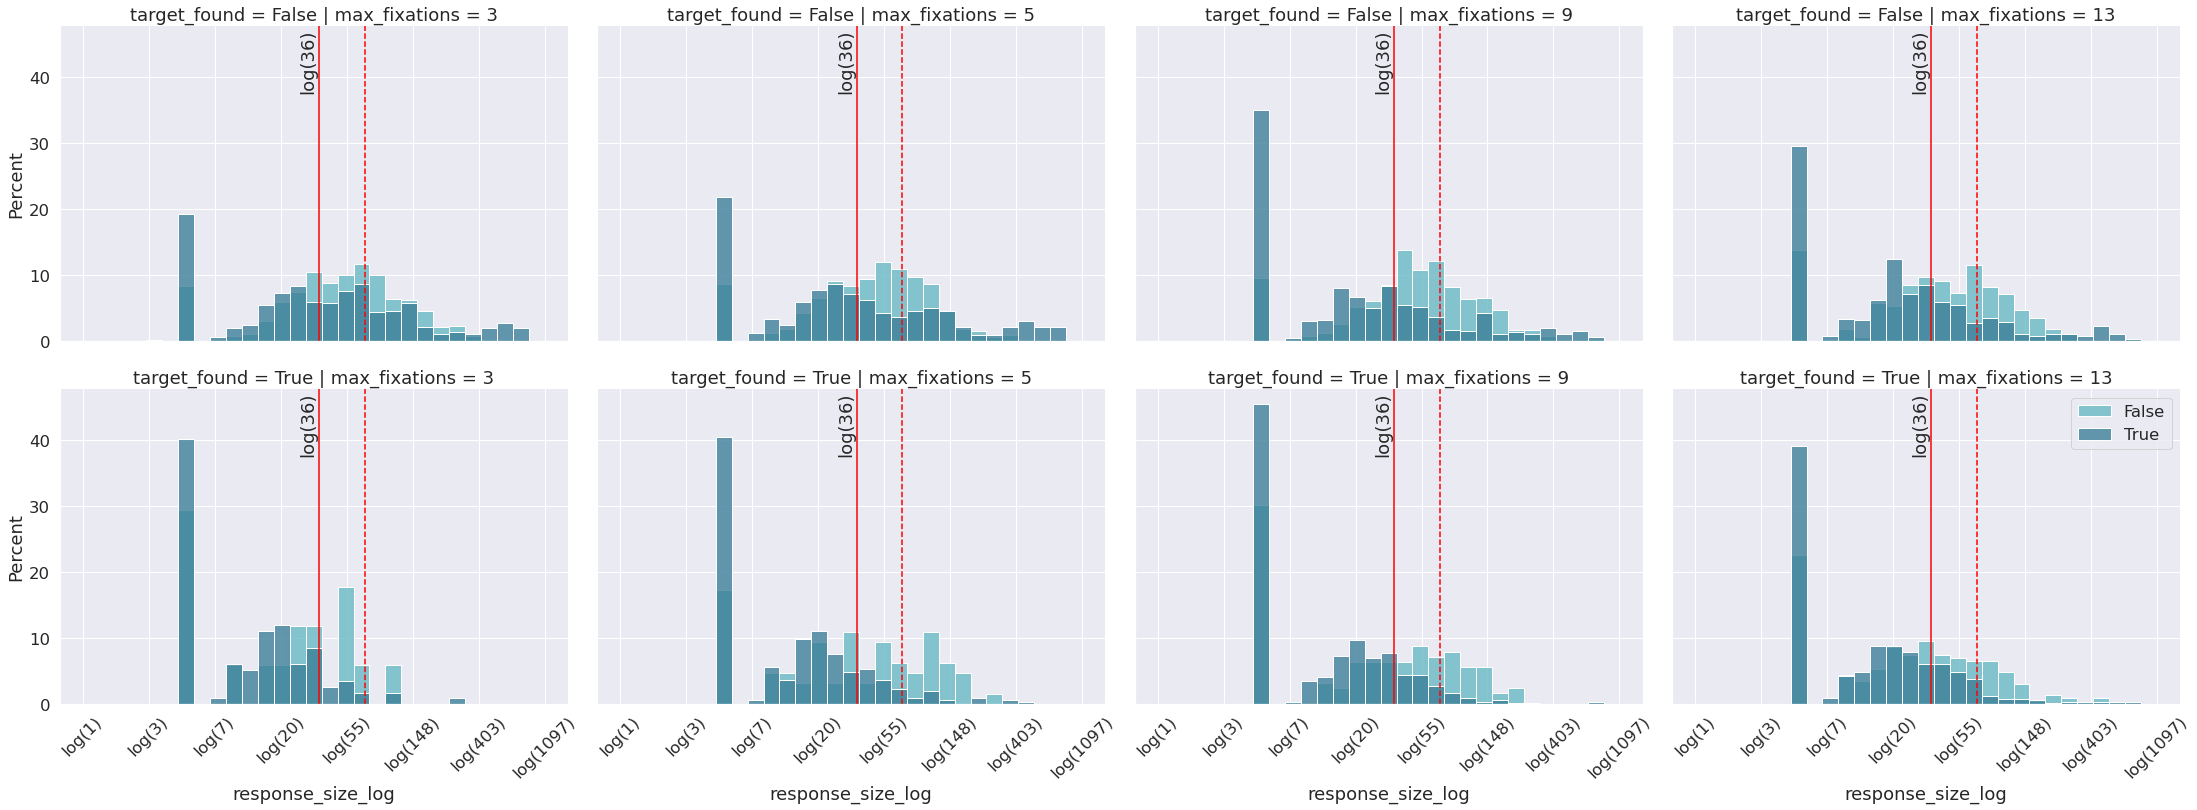

In [95]:
# response_size_log
var = "response_size_log"
grid = sns.FacetGrid(responses_data, col="max_fixations", row='target_found', hue='target_found_response',
                    palette="GnBu_d", height=5.8, aspect=1.33)
bins_hist = np.linspace(0,7,30)
grid.map(sns.histplot, var,bins=bins_hist, stat='percent', alpha=0.8, common_norm=False);
for i, ax in enumerate(grid.axes.ravel()):
    ax.axvline(np.log(36),color='red')
    ax.axvline(np.log(72),color='red',ls='--')
    trans = ax.get_xaxis_transform()
    ax.text(np.log(36)-0.3, .8, 'log(36)', transform=trans, rotation=90)
    if i > 3:
        ax.set_xticks(range(8))
        ax.set_xticklabels([f'log({np.exp(x):.0f})' for x in range(8)], rotation=45)
    
grid.tight_layout()
plt.legend()
plt.savefig(os.path.join(figs_path, f'grid_{var}.png'))

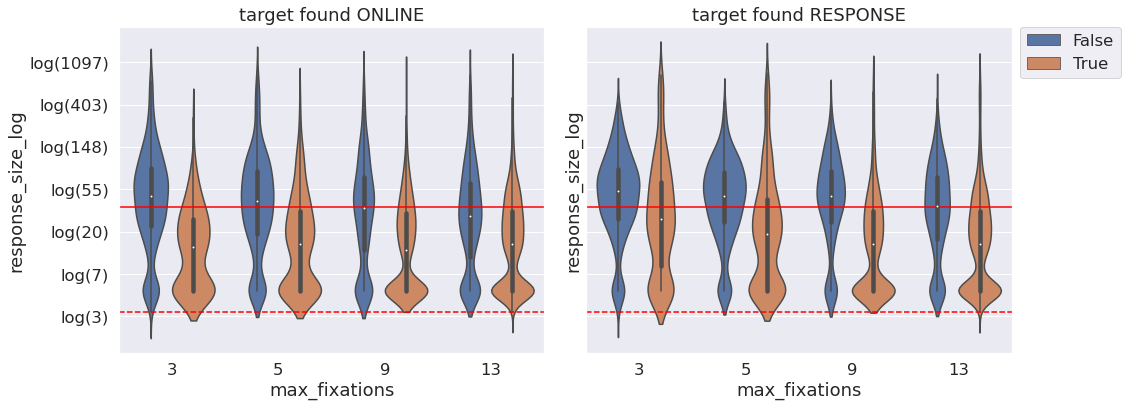

In [96]:
_,ax=plt.subplots(1,2, sharey=True, figsize=(16,6))

g = sns.violinplot(x='max_fixations',
            y=var,
            hue='target_found',
            data=responses_data,
            ax=ax[0])

ax[0].legend([], frameon=False)
ax[0].set_title('target found ONLINE')
ax[0].set_yticks(range(8))
ax[0].set_yticklabels([f'log({np.exp(x):.0f})' for x in range(8)])
sns.violinplot(x='max_fixations',
            y=var,
            hue='target_found_response',
            data=responses_data,
            ax=ax[1])
ax[1].set_title('target found RESPONSE')
ax[0].axhline(np.log(36),color='red')
ax[0].axhline(np.log(3),color='red', ls='--')
ax[1].axhline(np.log(36),color='red')
ax[1].axhline(np.log(3),color='red', ls='--')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.savefig(os.path.join(figs_path, f'grid_{var}_violinplot.png'))

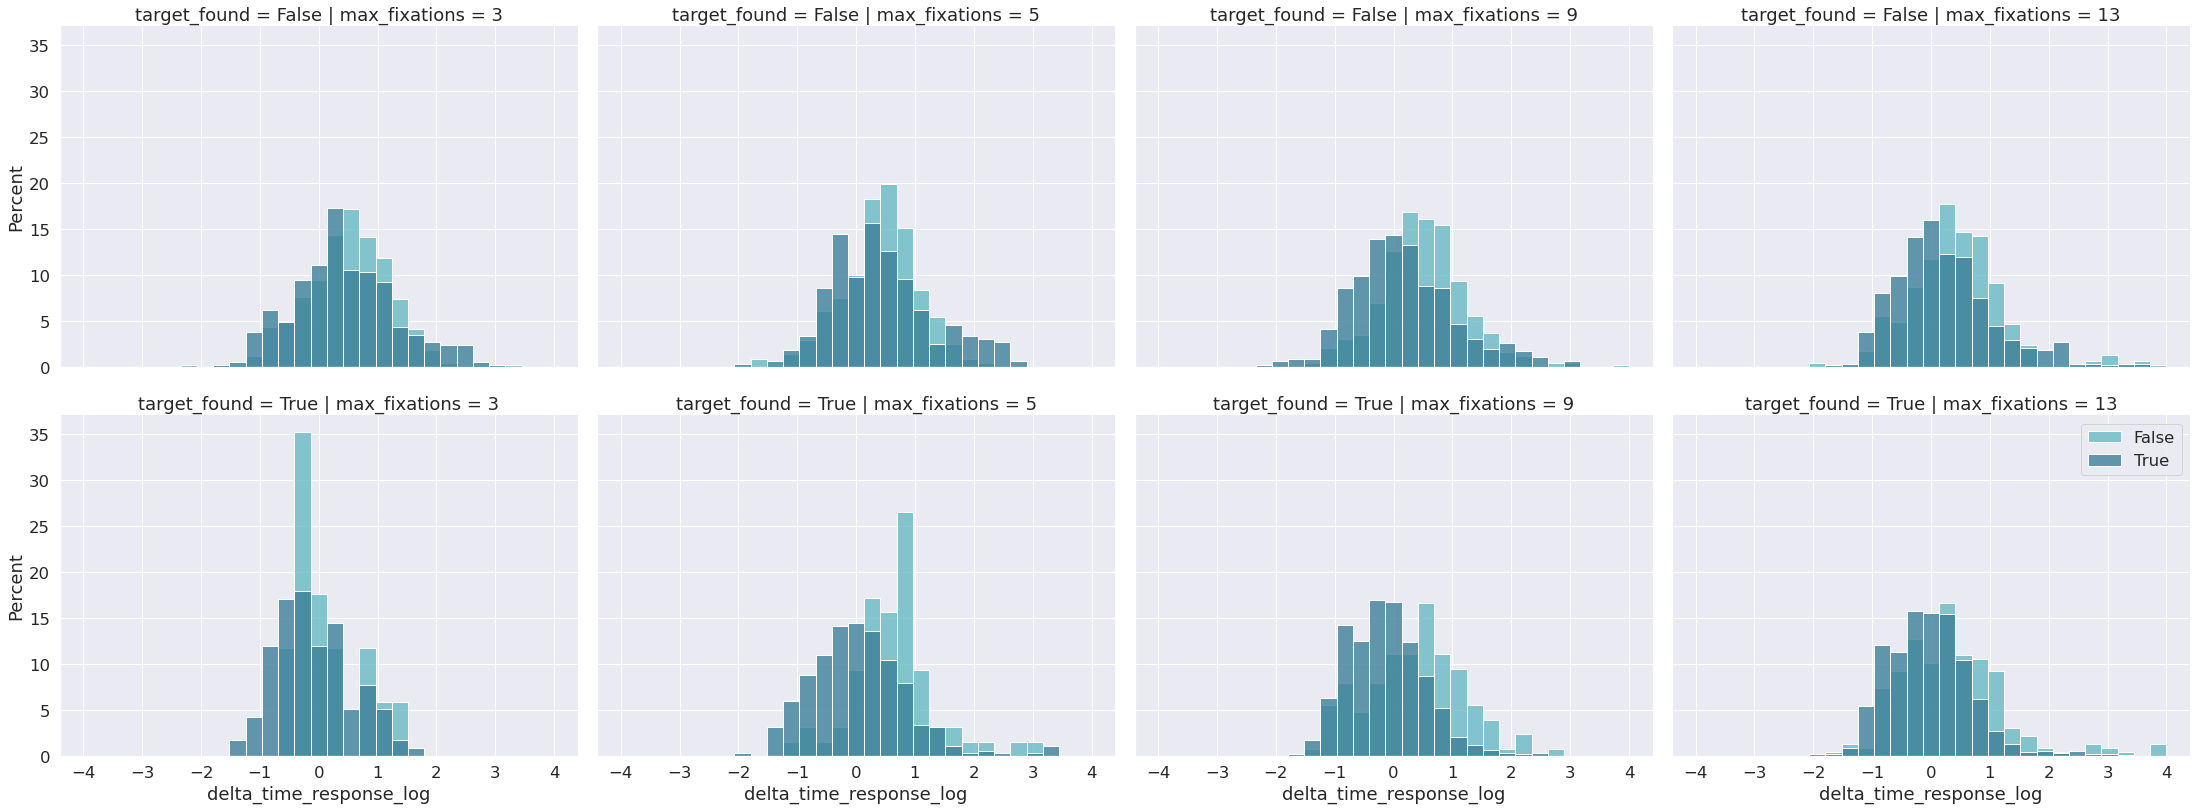

In [97]:
# delta_time_response_log
var = "delta_time_response_log"
grid = sns.FacetGrid(responses_data, col="max_fixations", row='target_found', hue='target_found_response',
                    palette="GnBu_d", height=5.8, aspect=1.33)

bins_hist = np.linspace(-4,4,30)
grid.map(sns.histplot, var, bins=bins_hist, stat='percent', alpha=0.8, common_norm=False);

grid.tight_layout()
plt.legend()
plt.savefig(os.path.join(figs_path, f'grid_{var}.png'))


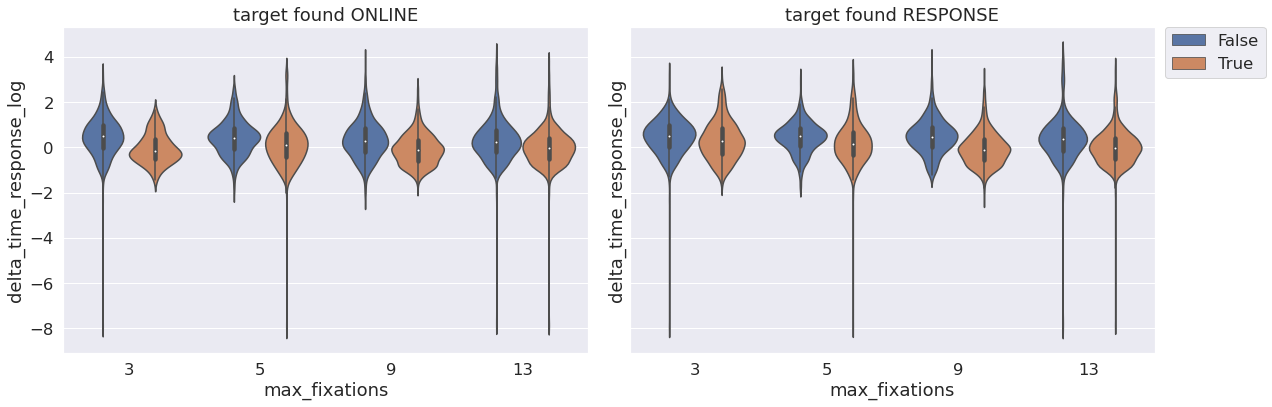

In [98]:
_,ax=plt.subplots(1,2, sharey=True, figsize=(18,6))

g = sns.violinplot(x='max_fixations',
            y=var,
            hue='target_found',
            data=responses_data,
            ax=ax[0])

ax[0].legend([], frameon=False)
ax[0].set_title('target found ONLINE')
sns.violinplot(x='max_fixations',
            y=var,
            hue='target_found_response',
            data=responses_data,
            ax=ax[1])
ax[1].set_title('target found RESPONSE')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.savefig(os.path.join(figs_path, f'grid_{var}_violinplot.png'))

## Análisis agrupado (4-cat)

Hay básicamente 4 grupos dependiendo si encontró el target de manera online (TFO) y si lo encontró con la respuesta (TFR):

- TFO & TFR: una especie de True Positive, lo vió y lo encontró 
- ~TFO & TFR: no lo vió pero tiene una idea de donde puede estar 
- TFO & ~TFR: lo vió pero no lo encontró
- ~TFO & ~TFR: no lo encontró ni lo vió

In [99]:
responses_data.head()

subj                              img  max_fixations  scanpath_length  \
0    41      grayscale_11_opensource.jpg             13               10   
1    41  grayscale_18_housebeautiful.jpg              9               10   
2    41          grayscale_100_oliva.jpg              5                3   
3    41           grayscale_17_oliva.jpg              3                2   
4    41  grayscale_16_housebeautiful.jpg              3                4   

   target_found  target_found_response  response_size  \
0         False                  False             29   
1         False                  False             47   
2          True                  False             19   
3         False                  False             35   
4         False                  False             19   

   distance_response_to_target  distance_to_last_fix  delta_time_response  \
0                   266.810794            213.164661            49.599536   
1                   329.200547            411.615026             9.666707   
2                   202.054448            204.544005             5.633140   
3                   297.692795            208.923431             4.266648   
4                   568.198029            223.650531             2.900187   

   response_x  response_y  target_bbox_x  target_bbox_y  \
0       486.0       447.0            228            559   
1       520.0       538.0            797            400   
2       714.0       218.0            713            381   
3       433.0       316.0            186            490   
4       762.0       442.0            158            421   

   response_target_relative_x  response_target_relative_y  \
0                      -258.0                       112.0   
1                       277.0                      -138.0   
2                        -1.0                       163.0   
3                      -247.0                       174.0   
4                      -604.0                       -21.0   

   delta_time_response_log  distance_response_to_target_log  \
0                 3.903981                         5.586540   
1                 2.268688                         5.796667   
2                 1.728667                         5.308537   
3                 1.450829                         5.696062   
4                 1.064775                         6.342470   

   distance_to_last_fix_log  response_size_log  
0                  5.362065           3.367296  
1                  6.020089           3.850148  
2                  5.320783           2.944439  
3                  5.341968           3.555348  
4                  5.410085           2.944439

In [100]:
def cat_trial(row):
    if row['target_found'] and row['target_found_response']:
        return 'TFO & TFR'
    elif ~row['target_found'] and row['target_found_response']:
        return '~TFO & TFR'
    elif row['target_found'] and ~row['target_found_response']:
        return 'TFO & ~TFR'
    elif ~row['target_found'] and ~row['target_found_response']:
        return '~TFO & ~TFR'
    else:
        return 'ERROR'
responses_data_logiliar_col = []
for idx, row in responses_data.iterrows():
    responses_data_logiliar_col.append(cat_trial(row))
responses_data['found_category'] = responses_data_logiliar_col
responses_data.found_category.value_counts()

TFO & TFR      3322
~TFO & ~TFR    1845
~TFO & TFR     1704
TFO & ~TFR      437
Name: found_category, dtype: int64

In [101]:
# Separo los casos donde no encontraron el target online pero si la respuesta
online_not_found_response_found = ~responses_data.target_found & responses_data.target_found_response
responses_data['online_not_found_response_found'] = online_not_found_response_found
print(responses_data.online_not_found_response_found.sum())
responses_data.target_found.value_counts()


1704


True     3759
False    3549
Name: target_found, dtype: int64

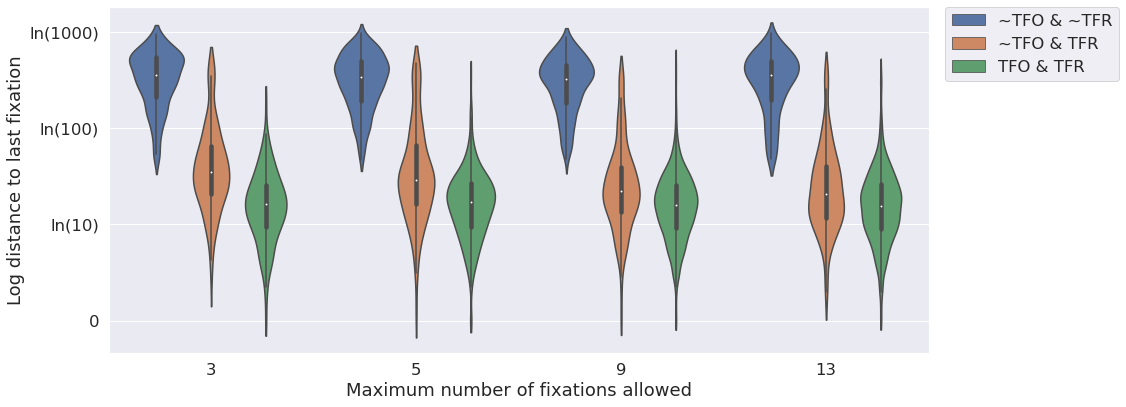

In [43]:
#var = "response_size_log"
#var = "distance_to_last_fix_log"
var = "distance_response_to_target_log"

# grid = sns.FacetGrid(responses_data[responses_data.online_not_found_response_found], col="max_fixations",
#                     palette="GnBu_d", height=7, aspect=1.2)
# 
# bins_hist = np.linspace(0,7,30)
# grid.map(sns.histplot, var, bins=bins_hist, stat='percent', alpha=0.8, common_norm=False);
# for i, ax in enumerate(grid.axes.ravel()):
#     ax.axvline(np.log(36),color='red')
#     ax.axvline(np.log(72),color='red',ls='--')
#     trans = ax.get_xaxis_transform()
#     ax.text(np.log(36)-0.3, .8, 'log(36)', transform=trans, rotation=90)
#     if i > 3:
#         ax.set_xticks(range(8))
#         ax.set_xticklabels([f'log({np.exp(x):.0f})' for x in range(8)], rotation=45)

_,ax=plt.subplots(1,1, sharey=True, figsize=(16,6))

g = sns.violinplot(x='max_fixations',
            y=var,
            hue='found_category',
            data=responses_data[responses_data.found_category != 'TFO & ~TFR'],
            cut=np.log(3),
            ax=ax)
#ax.set_title('Response size according max_fix and trial type')

#ax.axhline(np.log(36),color='red')
#ax.axhline(np.log(3),color='red', ls='--')
# estra pedido Juan
ax.set_xlabel('Maximum number of fixations allowed')

#ax.set_ylabel('Log response size')
ax.set_ylabel('Log distance to target')

#ax.set_yticks(range(8))
ax.set_yticks([0, np.log(10), np.log(100), np.log(1000)])
#ax.set_yticklabels([f'log({np.exp(x):.0f})' for x in range(8)])
ax.set_yticklabels(['0','ln(10)', 'ln(100)', 'ln(1000)'])
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.savefig(os.path.join(figs_path, f'{var}_found_category.png'))

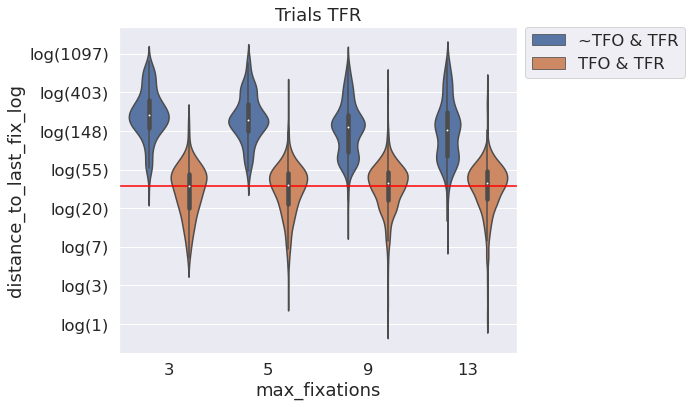

In [103]:
var = "distance_to_last_fix_log"

_,ax=plt.subplots(1,1, sharey=True, figsize=(10,6))

g = sns.violinplot(x='max_fixations',
            y=var,
            hue='found_category',
            data=responses_data[responses_data.found_category.isin(['TFO & TFR', '~TFO & TFR'])],
            ax=ax)
ax.set_title('Trials TFR')
ax.axhline(np.log(36),color='red')
ax.set_yticks(range(8))
ax.set_yticklabels([f'log({np.exp(x):.0f})' for x in range(8)])
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.savefig(os.path.join(figs_path, f'{var}_found_response.png'))

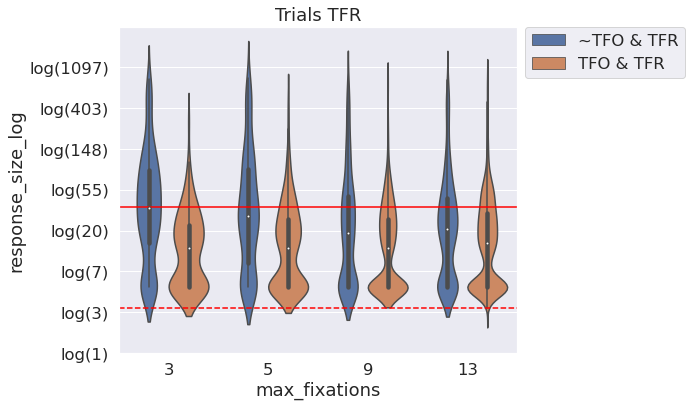

In [104]:
var = "response_size_log"

_,ax=plt.subplots(1,1, sharey=True, figsize=(10,6))

g = sns.violinplot(x='max_fixations',
            y=var,
            hue='found_category',
            data=responses_data[responses_data.found_category.isin(['TFO & TFR', '~TFO & TFR'])],
            ax=ax)
ax.set_title('Trials TFR')
ax.axhline(np.log(36),color='red')
ax.set_yticks(range(8))
ax.set_yticklabels([f'log({np.exp(x):.0f})' for x in range(8)])
ax.axhline(np.log(3),color='red', ls='--')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.savefig(os.path.join(figs_path, f'{var}_found_response.png'))

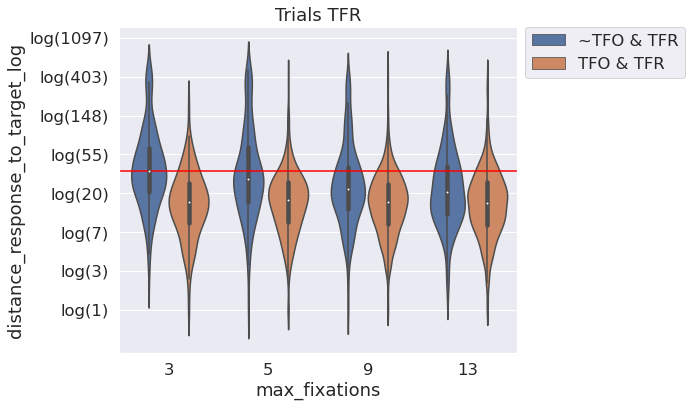

In [105]:
# Solamente por debug
var = "distance_response_to_target_log"

_,ax=plt.subplots(1,1, sharey=True, figsize=(10,6))

g = sns.violinplot(x='max_fixations',
            y=var,
            hue='found_category',
            data=responses_data[responses_data.found_category.isin(['TFO & TFR', '~TFO & TFR'])],
            ax=ax)

ax.set_title('Trials TFR')
ax.axhline(np.log(36),color='red')
ax.set_yticks(range(8))
ax.set_yticklabels([f'log({np.exp(x):.0f})' for x in range(8)])
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.savefig(os.path.join(figs_path, f'{var}_found_response.png'))

### Adicional: transformaciones Box-Cox?

-0.19521072001417542


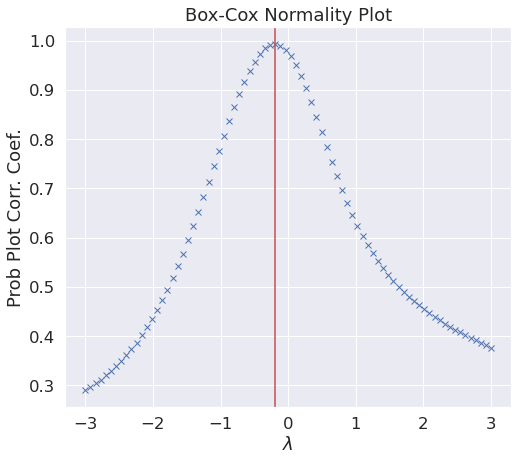

In [106]:
import scipy.stats as scp
_,ax=plt.subplots(1,1, sharey=True, figsize=(8,7))
x = responses_data[(responses_data.target_found)&(responses_data.distance_response_to_target>0)].loc[:,'distance_response_to_target']
prob = scp.boxcox_normplot(x,la=-3,lb=3, plot=ax)
_, maxlog = scp.boxcox(x)
ax.axvline(maxlog, color='r');
print(maxlog)


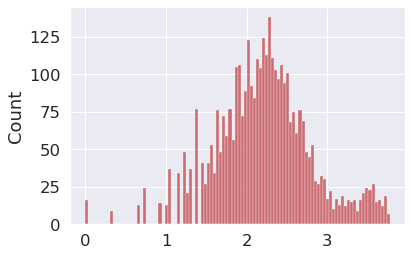

In [107]:
x_bc = scp.boxcox(x, maxlog)
sns.histplot(x_bc, bins=100, color='r', alpha=0.8);

### Online found y respuesta not found
La pregunta aca es si encontraron realmente el target en estos casos. Una cosa que podemos usar es el tiempo de fijación en el cual observaron el target

In [108]:
print('Total de trials donde se encontró el target online:',responses_data.target_found.sum())

print('Total de trials donde se encontró el target en respuesta:', 
        responses_data.target_found_response.sum())

print('Total de trials con target found online y respuesta:',
        responses_data[(responses_data.target_found) & (responses_data.target_found_response)].shape[0])
        
print('Total de trials con target found online pero que no acertaron en respuesta:',
        responses_data[(responses_data.target_found) & ~(responses_data.target_found_response)].shape[0])


Total de trials donde se encontró el target online: 3759
Total de trials donde se encontró el target en respuesta: 5026
Total de trials con target found online y respuesta: 3322
Total de trials con target found online pero que no acertaron en respuesta: 437


<AxesSubplot:xlabel='max_fixations', ylabel='distance_response_to_target'>

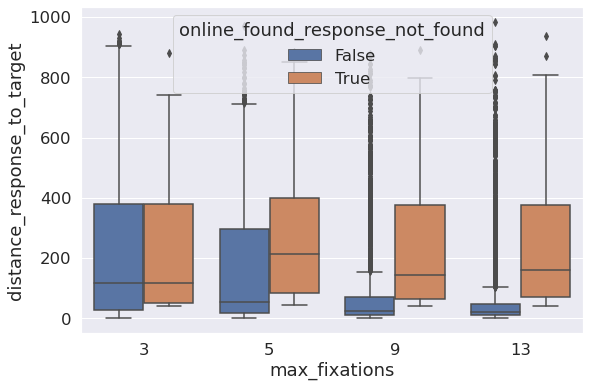

In [109]:
# Analicemos los sujetos que se supone que vieron el target pero en la respuesta no lo vieron

online_found_response_not_found = responses_data.target_found & ~responses_data.target_found_response
responses_data['online_found_response_not_found'] = online_found_response_not_found

_,ax=plt.subplots(1,1, figsize=(9,6))

# Boxplot de los casos encontrados online pero no con la respuesta
sns.boxplot(x='max_fixations',
            y='distance_response_to_target',
            hue='online_found_response_not_found',
            data=responses_data,
            ax=ax
            )

## Curvas de target found vs ntf

<AxesSubplot:xlabel='max_fixations', ylabel='distance_response_to_target'>

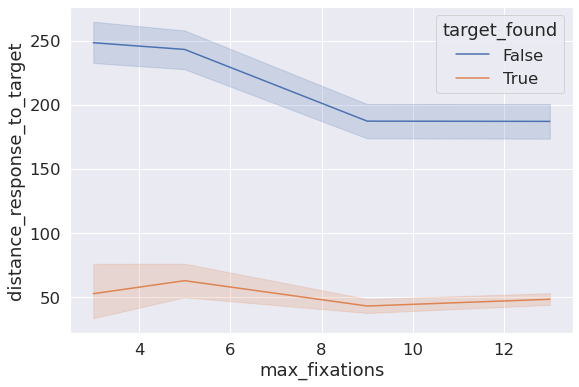

In [110]:
_,ax=plt.subplots(1,1, figsize=(9,6))

sns.lineplot(x='max_fixations',
            y='distance_response_to_target',
            #hue='online_found_response_not_found',
            hue='target_found',
            data=responses_data,
            ax=ax
            )

<AxesSubplot:xlabel='max_fixations', ylabel='response_size'>

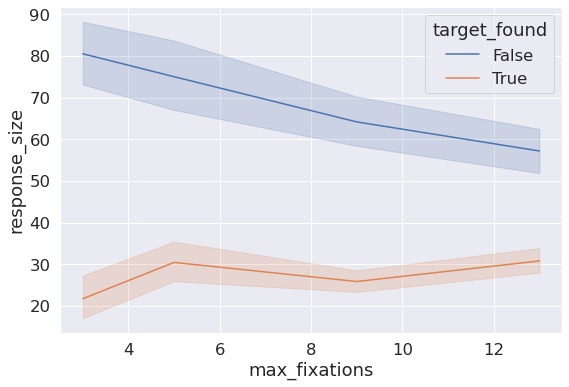

In [111]:
_,ax=plt.subplots(1,1, figsize=(9,6))
sns.lineplot(x='max_fixations',
            y='response_size',
            #hue='online_found_response_not_found',
            hue='target_found',
            data=responses_data,
            ax=ax
            )

<AxesSubplot:xlabel='max_fixations', ylabel='distance_to_last_fix'>

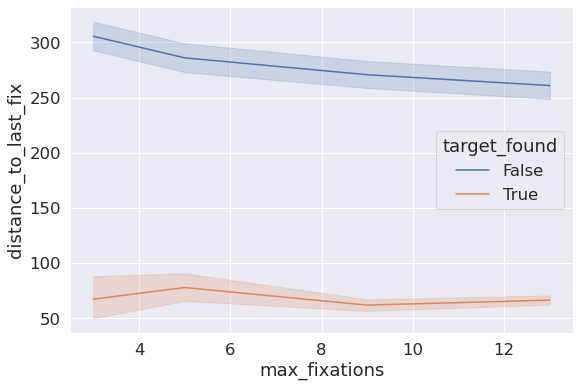

In [112]:
_,ax=plt.subplots(1,1, figsize=(9,6))
sns.lineplot(x='max_fixations',
            y='distance_to_last_fix',
            #hue='online_found_response_not_found',
            hue='target_found',
            data=responses_data,
            ax=ax
            )

### Usando los sujetos como un punto

In [151]:
def plot_column_max_fix_tf(data, column_plot='distance_response_to_target', kind ='scatter', save_path = figs_path):
    # cada punto es la media de los trials de un tipo de target_found y max_fixations para un sujeto
    # es decir que cada sujeto tiene 8 puntos (4 max_fixations x 2 target_found)
    g = data.groupby(['subj','target_found','max_fixations']).mean()[column_plot].reset_index()
    
    _,ax=plt.subplots(1,1, figsize=(9,6))
    if kind == 'scatter':
        sns.stripplot(x='max_fixations',
                     y=column_plot,
                     hue='target_found',
                     data=g,
                     ax=ax
                     )
        plt.savefig(path.join(save_path, f'scatterplot_{column_plot}.png'))
    elif kind =='line':
        sns.lineplot(x='max_fixations',
                     y=column_plot,
                     hue='target_found',
                     data=g,
                     ci='sd',
                     ax=ax
                     )    
        plt.savefig(path.join(save_path, f'lineplot_{column_plot}.png'))
    else:
        raise ValueError('kind must be "scatter" or "line"')
    plt.tight_layout()
    return g

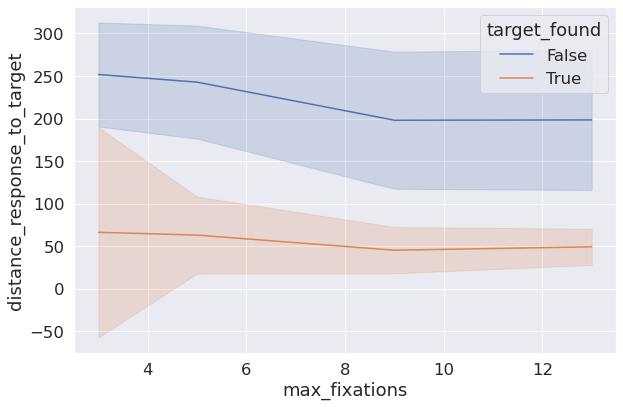

In [152]:
g = plot_column_max_fix_tf(responses_data, column_plot='distance_response_to_target', kind ='line')

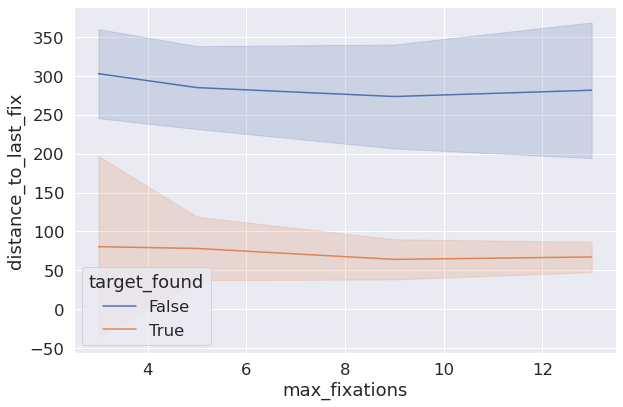

In [154]:
g = plot_column_max_fix_tf(responses_data, column_plot='distance_to_last_fix', kind ='line')

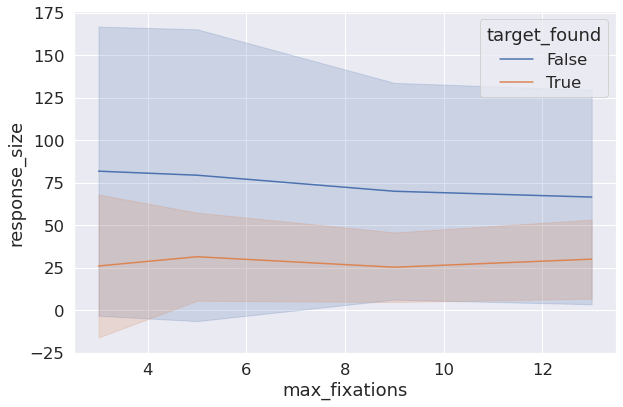

In [155]:
g = plot_column_max_fix_tf(responses_data, column_plot='response_size', kind ='line')

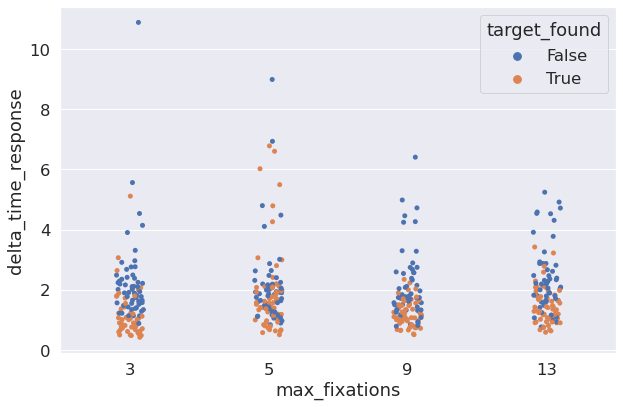

In [156]:
g = plot_column_max_fix_tf(responses_data, column_plot='delta_time_response')

# Modelado de la respuesta

Esta parte no esta explorada en profundidad

## Modelito lineal

La idea es tratar de ver si existe una relación entre que tan lejos estuvo del target al tratar de adivinar, la pregunta a responder sería:

- ¿Los sujetos juzgan bien su decisión? Es decir, si a medida que le acertaron al target en su respuesta, ¿el tamaño de la respuesta subjetiva es mas pequeño?
- Y si desagregamos por target found, los que vieron el target, ¿su tamaño genera una mejor respuesta subjetiva?

(0.0, 400.0)

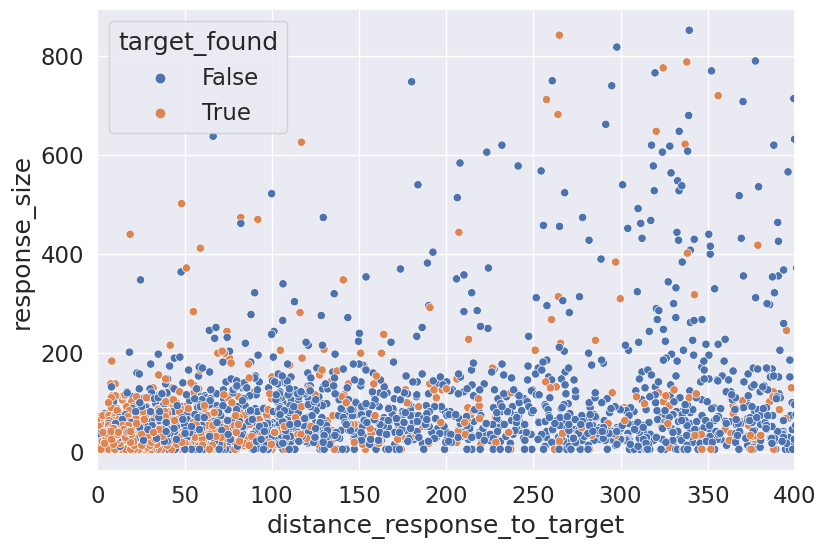

In [22]:
fig, ax = plt.subplots(1,1, figsize=(9,6))
sns.scatterplot(x='distance_response_to_target', y='response_size',hue='target_found', data=responses_data, ax=ax);
ax.set_xlim(0,400)

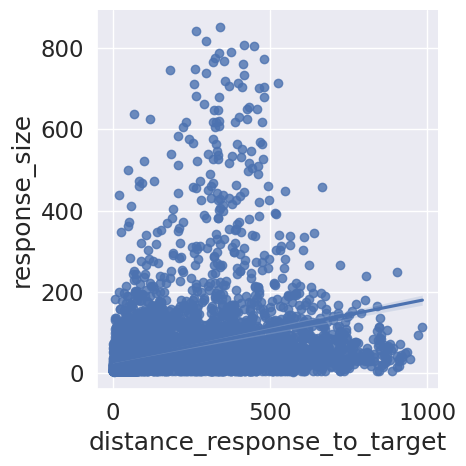

In [23]:
sns.lmplot(x='distance_response_to_target', y='response_size', data=responses_data);

In [24]:
import statsmodels.api as sm
X = sm.add_constant(responses_data['distance_response_to_target'].to_numpy())
y = responses_data['response_size'].to_numpy().reshape(-1,1)
mod = sm.OLS(y,X)
res = mod.fit()
#print(res.summary())

print(f'All estimated params, constant: {res._results.params[0]:.2f}, distance_response_to_target: {res._results.params[1]:.2f}')

All estimated params, constant: 28.23, distance_response_to_target: 0.15


In [25]:
# desagregamos por target found
responses_data_found = responses_data.query('target_found==True')
responses_data_not_found = responses_data.query('target_found==False')
print(responses_data_found.shape)
print(responses_data_not_found.shape)

(3759, 16)
(3549, 16)


In [26]:
# response_size vs distance to target for target found
import statsmodels.api as sm
X = sm.add_constant(responses_data_found['distance_response_to_target'].to_numpy())
y = responses_data_found['response_size'].to_numpy().reshape(-1,1)
mod = sm.OLS(y,X)
res_found = mod.fit()
#print(res_found.summary())

print(f'Found estimated params, constant: {res_found._results.params[0]:.2f}, distance_response_to_target: {res_found._results.params[1]:.2f}')

# response_size vs distance to target for target not found
X = sm.add_constant(responses_data_not_found['distance_response_to_target'].to_numpy())
y = responses_data_not_found['response_size'].to_numpy().reshape(-1,1)
mod = sm.OLS(y,X)
res_not_found = mod.fit()
#print(res_not_found.summary())

print(f'Not found estimated params, constant: {res_not_found._results.params[0]:.2f}, distance_response_to_target: {res_not_found._results.params[1]:.2f}')

Found estimated params, constant: 19.08, distance_response_to_target: 0.20
Not found estimated params, constant: 43.37, distance_response_to_target: 0.12


*Conclusion parcial*

Parece fuerte el efecto del intercept en el caso de que hayan encontrado el target, es decir que que parece que juzgan mejor sus respuestas. Algunos poxsibles todo's:
- Pasar los valores a angulos
- Son significativas esas diferencias?
- Tiene sentido meter mas regresiones en el medio?
- Chequeo de supuestos?

/home/gastonb/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


(7304, 19)


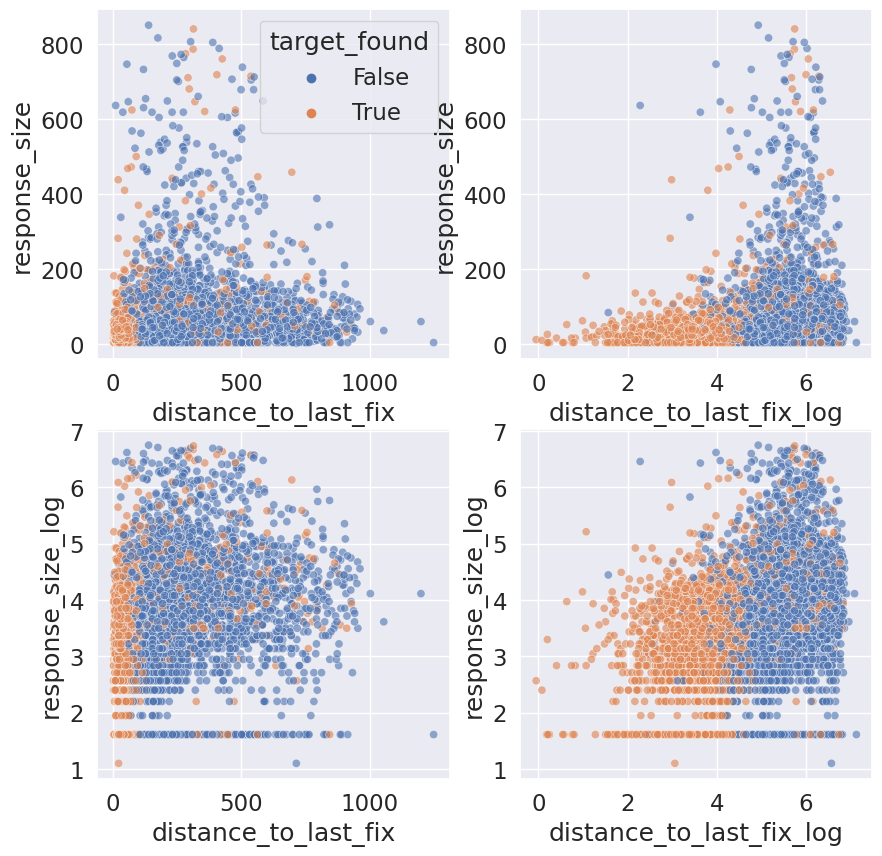

In [36]:
# lo mismo pero ahora consideramos todo en el dominio logaritmico
responses_data_log = responses_data.copy()
responses_data_log['distance_response_to_target_log'] = np.log(responses_data_log['distance_response_to_target'])
responses_data_log['response_size_log'] = np.log(responses_data_log['response_size'])
responses_data_log['distance_to_last_fix_log'] = np.log(responses_data_log['distance_to_last_fix'])
responses_data_log.replace(-np.Inf, np.nan,inplace=True)
responses_data_log.dropna(inplace=True)
print(responses_data_log.shape)
fig, ax = plt.subplots(2,2, figsize=(10,10))
sns.scatterplot(x='distance_to_last_fix', y='response_size',hue='target_found', data=responses_data_log, ax=ax[0,0], alpha=0.6);
sns.scatterplot(x='distance_to_last_fix', y='response_size_log',hue='target_found', data=responses_data_log, ax=ax[1,0], alpha=0.6, legend=False);
sns.scatterplot(x='distance_to_last_fix_log', y='response_size',hue='target_found', data=responses_data_log, ax=ax[0,1], alpha=0.6, legend=False);
sns.scatterplot(x='distance_to_last_fix_log', y='response_size_log',hue='target_found', data=responses_data_log, ax=ax[1,1], alpha=0.6, legend=False);
#ax[1].set_xlim(-1,8)
plt.show()

In [63]:
# Modelo lineal para log vs log todos los datos

def linear_model(X_col: str = 'distance_to_last_fix_log', 
                 y_col: str = 'response_size_log',
                 extra_filter: str = None,
                 data=responses_data_log,
                 do_partial_plot=True,
                 figsize=(9,5)):
    """_summary_

    Args:
        X_col (str, optional): Defaults to 'distance_to_last_fix_log'.
        y_col (str, optional): Defaults to 'response_size_log'.
        extra_filter (str, optional): Query to do to data like 'target_found==True'. Defaults to None.
        data (pd.DataFrame, optional): Pandas DataFrame that contains the previous columns. Defaults to responses_data_log.
        do_partial_plot (bool, optional): Do partial regression plot from stats models. Defaults to True.
        figsize (tuple, optional): Defaults to (9,5).

    Returns:
        _type_: _description_
    """
    
    if extra_filter is not None:
        data = data.query(extra_filter)
    X = sm.add_constant(data[X_col].to_numpy())
    y = data[y_col].to_numpy().reshape(-1,1)
    mod = sm.OLS(y,X)
    res = mod.fit()
    print(f'Linear model: {y_col} ~ 1 + {X_col}')
    print(f'Estimated params, constant: {res._results.params[0]:.2f}, {X_col}: {res._results.params[1]:.2f}')
    if do_partial_plot:
        fig = sm.graphics.plot_partregress_grid(res, fig=plt.figure(figsize=figsize))
        fig.tight_layout(pad=1.0)

    return res

Linear model: response_size_log ~ 1 + distance_to_last_fix_log
Estimated params, constant: 0.97, distance_to_last_fix_log: 0.47
eval_env: 1
eval_env: 1


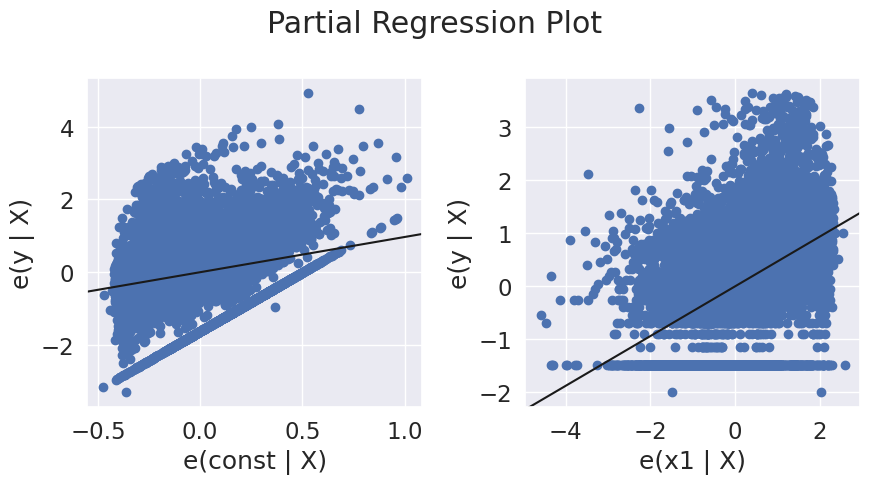

In [66]:
res = linear_model(X_col='distance_to_last_fix_log')

Linear model: response_size_log ~ 1 + distance_to_last_fix_log
Estimated params, constant: 1.18, distance_to_last_fix_log: 0.41
eval_env: 1
eval_env: 1


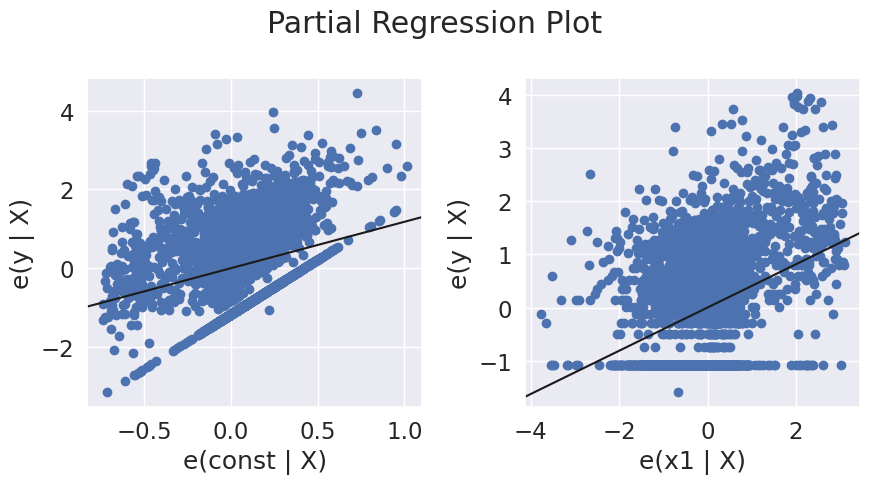

In [67]:
res = linear_model(X_col='distance_to_last_fix_log', extra_filter='target_found==True')

Linear model: response_size_log ~ 1 + distance_to_last_fix_log
Estimated params, constant: 0.88, distance_to_last_fix_log: 0.49
eval_env: 1
eval_env: 1


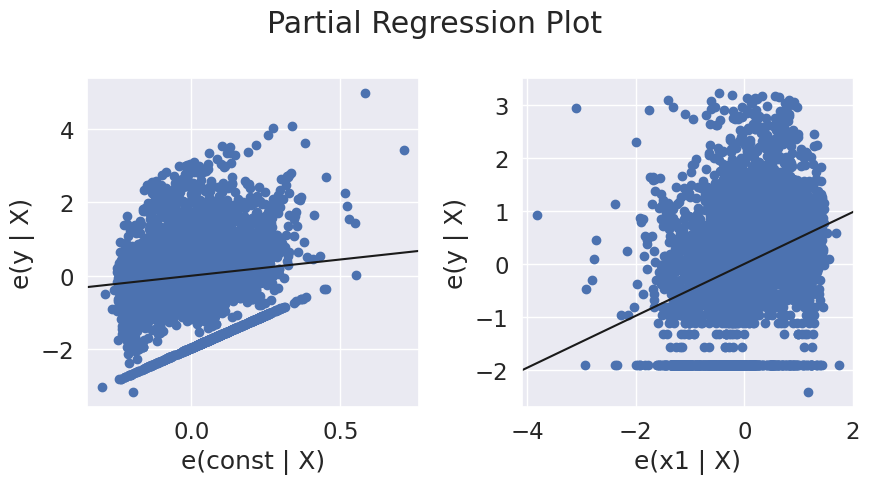

In [68]:
res = linear_model(X_col='distance_to_last_fix_log', extra_filter='target_found==False')

Linear model: response_size_log ~ 1 + distance_response_to_target_log
Estimated params, constant: 1.38, distance_response_to_target_log: 0.46
eval_env: 1
eval_env: 1


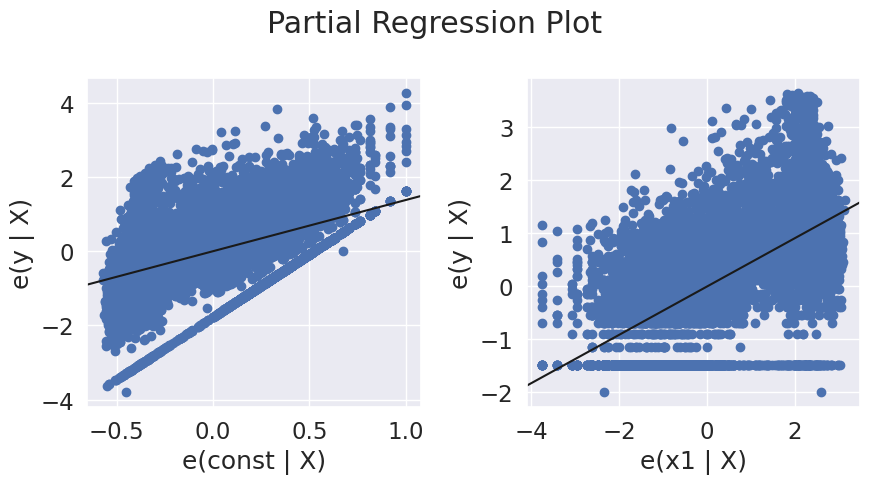

In [69]:
res = linear_model(X_col='distance_response_to_target_log')

Linear model: response_size_log ~ 1 + distance_response_to_target_log
Estimated params, constant: 1.42, distance_response_to_target_log: 0.43
eval_env: 1
eval_env: 1


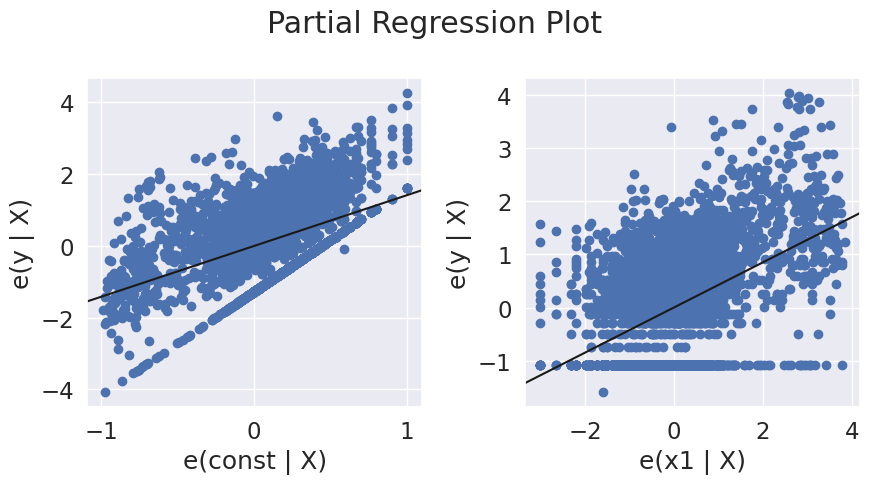

In [70]:
res = linear_model(X_col='distance_response_to_target_log', extra_filter='target_found==True')

Linear model: response_size_log ~ 1 + distance_response_to_target_log
Estimated params, constant: 1.54, distance_response_to_target_log: 0.43
eval_env: 1
eval_env: 1


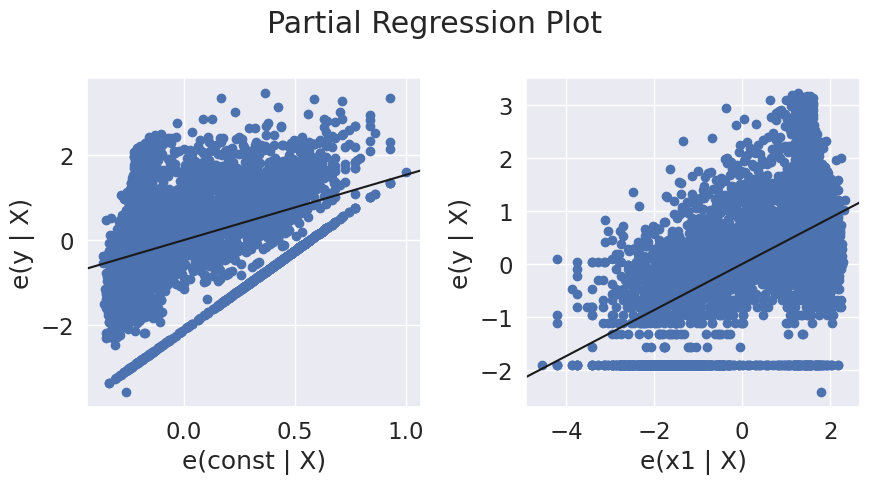

In [71]:
res = linear_model(X_col='distance_response_to_target_log', extra_filter='target_found==False')

*Conclusion parcial (logspace)*

Parece que la transformación al espacio logaritimo mata el efecto de la distancia al target de la respuesta objetiva, pero sigue estando la diferencia del efecto de la constante.
- Es significativo?

## Gaussian mixture

In [157]:
from sklearn.mixture import GaussianMixture
from scipy.stats import norm

def fit_gaussian_mixture(df, col, n_components=2):
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=0)
    # filter out the outliers if any    
    X = df.loc[:,col]
    X = X[X != -np.inf]
    X = X.to_numpy().reshape(-1,1)
    gmm.fit(X)

    # plot the data and the mixture of gaussians
    x = np.linspace(np.min(X), np.max(X)+5, len(X)).reshape(-1,1)
    y = np.exp(gmm.score_samples(x))
    _, ax = plt.subplots(1,2, figsize=(12,6)) 
    ax[0].plot(x,y, color='blue')
    ax[0].hist(X, density=True, bins=30,alpha=0.5, color='cornflowerblue');
    val, bins, _ = ax[1].hist(X, bins=30, density=True, alpha=0.5, color='cornflowerblue')
    #area = sum(np.diff(bins)*val)  +  sum(np.diff(bins)*val)
    for i in range(n_components):
        mean_i = gmm.means_[i][0]
        std_i = np.sqrt(gmm.covariances_[i][0])[0]
        weight_i = gmm.weights_[i]
        y = norm.pdf(x, mean_i, std_i)*weight_i
        ax[1].plot(x,y)

    return gmm

GaussianMixture(n_components=2, random_state=0)

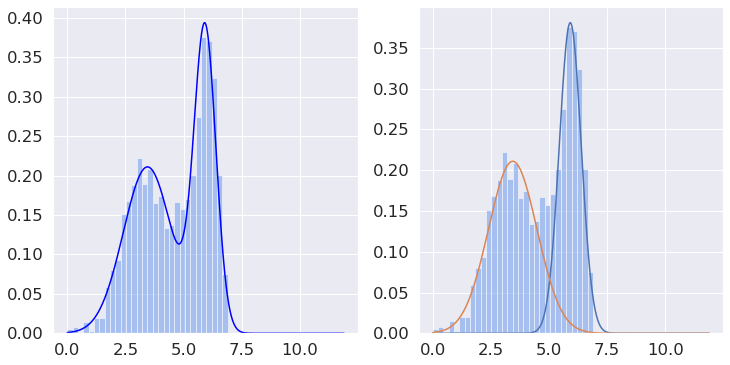

In [158]:
fit_gaussian_mixture(responses_data[~(responses_data.target_found)], col = 'distance_response_to_target_log' )

GaussianMixture(n_components=2, random_state=0)

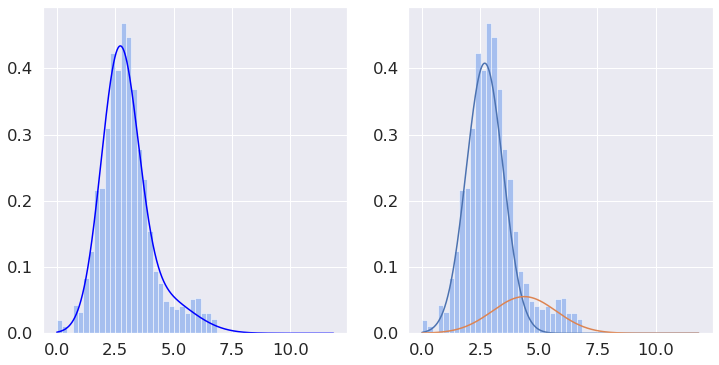

In [159]:
fit_gaussian_mixture(responses_data[responses_data.target_found], col = 'distance_response_to_target_log' )